**Analyse et segmentation de clientèle d'un magasin avec campagnes de marketing**
_Jules EXBRAYAT & Abdenour MADANI_

# Présentation

## Problématique

Quel est le client type de l'entreprise ?

Peut-on créer des groupes de clients, afin de cibler efficacement les potentiels clients et personnaliser la campagne marketing ?

## Jeu de données

In [247]:
# todo : ajouter une description / une partie pour parler du jeu de données
# "Ce jeu de données contient le profil de plusieurs clients d'une enseigne de grande distribution" \
# "Il contient les données de juillet 2012 à juillet 2014" \
# "Nous disposons des ventes en Vin, etc"

### Lecture des données

In [248]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.genmod.generalized_linear_model

In [249]:
np.random.seed(0)
sns.set_theme()

In [250]:
df = pd.read_csv("marketing_campaign.csv", sep="\t", index_col="ID", parse_dates=True)

### Présentation des variables

In [251]:
df.head()

Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
ID                                                                        
5524        1957  Graduation         Single  58138.0        0         0   
2174        1954  Graduation         Single  46344.0        1         1   
4141        1965  Graduation       Together  71613.0        0         0   
6182        1984  Graduation       Together  26646.0        1         0   
5324        1981         PhD        Married  58293.0        1         0   

     Dt_Customer  Recency  MntWines  MntFruits  ...  NumWebVisitsMonth  \
ID                                              ...                      
5524  04-09-2012       58       635         88  ...                  7   
2174  08-03-2014       38        11          1  ...                  5   
4141  21-08-2013       26       426         49  ...                  4   
6182  10-02-2014       26        11          4  ...                  6   
5324  19-01-2014       94       173         43  ...                  5   

      AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
ID                                                                           
5524             0             0             0             0             0   
2174             0             0             0             0             0   
4141             0             0             0             0             0   
6182             0             0             0             0             0   
5324             0             0             0             0             0   

      Complain  Z_CostContact  Z_Revenue  Response  
ID                                                  
5524         0              3         11         1  
2174         0              3         11         0  
4141         0              3         11         0  
6182         0              3         11         0  
5324         0              3         11         0  

[5 rows x 28 columns]

In [252]:
print(f"Il y a {df.shape[1]} variables et {df.shape[0]} individus.")

Il y a 28 variables et 2240 individus.


#### Variables

- ID: identifiant du client
- Year_Birth: numérique, année de naissance du client
- Education: qualitative, niveau d'éducation
- Marital_Status: qualitative, statut marital
- Income: numérique, revenu annuel en $
- Kidhome: numérique, nombre d'enfants en bas-âge
- Teenhome: numérique, nombre d'enfants adolescents
- Dt_Customer: date, date à laquelle le client s'est inscrit
- Recency: numérique, nombre de jours depuis le dernier achat
- Complain: catégorique, est-ce que le client s'est plaint les 2 dernières années (0 ou 1)

#### Products

- MntWines: numérique, argent dépensé les 2 dernières années en vin
- MntFruits: numérique, argent dépensé les 2 dernières années en fruits
- MntMeatProducts: numérique, argent dépensé les 2 dernières années en viande
- MntFishProducts: numérique, argent dépensé les 2 dernières années en poisson
- MntSweetProducts: numérique, argent dépensé les 2 dernières années en bonbons / gâteaux
- MntGoldProds: numérique, argent dépensé les 2 dernières années en bijoux / or

#### Promotion

- NumDealsPurchases: numérique, nombre d'achats effectués avec une promotion
- AcceptedCmp1: catégorique, le client a-t-il acheté durant la campagne promotionnelle numéro 1 (1 s'il a acheté, 0 sinon)
- AcceptedCmp2: pareil pour la campagne numéro 2
- AcceptedCmp3: pareil pour la campagne numéro 3
- AcceptedCmp4: pareil pour la campagne numéro 4
- AcceptedCmp5: pareil pour la campagne numéro 5
- Response: catégorique, 1 si le client a acheté durant la dernière campagne, 0 sinon (potentielle variable à prédire)

#### Place

- NumWebPurchases: numérique, nombre d'achats effectués sur le site Internet
- NumCatalogPurchases: numérique, nombre d'achats effectués via le catalogue
- NumStorePurchases: numérique, nombre d'achats effectués en magasin
- NumWebVisitsMonth: numérique, nombre de visites sur le site Internet le dernier mois


Nous séparons les variables numériques des variables catégoriques pour plus de commodités.

In [253]:
var_numeriques = [
    "Year_Birth",
    "Income",
    "Kidhome",
    "Teenhome",
    "Recency",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth",
]

In [254]:
var_categoriques = [
    "Education",
    "Marital_Status",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response",
]

Nous convertissons les variables catégoriques en type `category`. (Nous les convertissons au préalable en type `string` car cela facilite l'affichage de la légende avec Matplotlib et Seaborn)

In [255]:
df[var_categoriques] = df[var_categoriques].astype(str).astype("category")

Nous convertissons les variables au format date.

In [256]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%d-%m-%Y")

In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 5524 to 9405
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Year_Birth           2240 non-null   int64         
 1   Education            2240 non-null   category      
 2   Marital_Status       2240 non-null   category      
 3   Income               2216 non-null   float64       
 4   Kidhome              2240 non-null   int64         
 5   Teenhome             2240 non-null   int64         
 6   Dt_Customer          2240 non-null   datetime64[ns]
 7   Recency              2240 non-null   int64         
 8   MntWines             2240 non-null   int64         
 9   MntFruits            2240 non-null   int64         
 10  MntMeatProducts      2240 non-null   int64         
 11  MntFishProducts      2240 non-null   int64         
 12  MntSweetProducts     2240 non-null   int64         
 13  MntGoldProds         2240 non-

Nous avons 9 variables catégoriques, 18 variables quantitatives (dont 17 entières) ainsi qu'une variable de type date.

In [258]:
# todo: inclure "Découverte" et "Nettoyage" dans une grande partie "Analyse exploratoire des données" ?

# Découverte des données

## Analyse univariée

In [259]:
df[var_numeriques].describe()

Year_Birth         Income      Kidhome     Teenhome      Recency  \
count  2240.000000    2216.000000  2240.000000  2240.000000  2240.000000   
mean   1968.805804   52247.251354     0.444196     0.506250    49.109375   
std      11.984069   25173.076661     0.538398     0.544538    28.962453   
min    1893.000000    1730.000000     0.000000     0.000000     0.000000   
25%    1959.000000   35303.000000     0.000000     0.000000    24.000000   
50%    1970.000000   51381.500000     0.000000     0.000000    49.000000   
75%    1977.000000   68522.000000     1.000000     1.000000    74.000000   
max    1996.000000  666666.000000     2.000000     2.000000    99.000000   

          MntWines    MntFruits  MntMeatProducts  MntFishProducts  \
count  2240.000000  2240.000000      2240.000000      2240.000000   
mean    303.935714    26.302232       166.950000        37.525446   
std     336.597393    39.773434       225.715373        54.628979   
min       0.000000     0.000000         0.000000         0.000000   
25%      23.750000     1.000000        16.000000         3.000000   
50%     173.500000     8.000000        67.000000        12.000000   
75%     504.250000    33.000000       232.000000        50.000000   
max    1493.000000   199.000000      1725.000000       259.000000   

       MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
count       2240.000000   2240.000000        2240.000000      2240.000000   
mean          27.062946     44.021875           2.325000         4.084821   
std           41.280498     52.167439           1.932238         2.778714   
min            0.000000      0.000000           0.000000         0.000000   
25%            1.000000      9.000000           1.000000         2.000000   
50%            8.000000     24.000000           2.000000         4.000000   
75%           33.000000     56.000000           3.000000         6.000000   
max          263.000000    362.000000          15.000000        27.000000   

       NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  
count          2240.000000        2240.000000        2240.000000  
mean              2.662054           5.790179           5.316518  
std               2.923101           3.250958           2.426645  
min               0.000000           0.000000           0.000000  
25%               0.000000           3.000000           3.000000  
50%               2.000000           5.000000           6.000000  
75%               4.000000           8.000000           7.000000  
max              28.000000          13.000000          20.000000

In [260]:
df[var_categoriques].describe()

Education Marital_Status Complain AcceptedCmp1 AcceptedCmp2  \
count         2240           2240     2240         2240         2240   
unique           5              8        2            2            2   
top     Graduation        Married        0            0            0   
freq          1127            864     2219         2096         2210   

       AcceptedCmp3 AcceptedCmp4 AcceptedCmp5 Response  
count          2240         2240         2240     2240  
unique            2            2            2        2  
top               0            0            0        0  
freq           2077         2073         2077     1906

In [261]:
# todo: commenter

## Visualisation

### Variables numériques

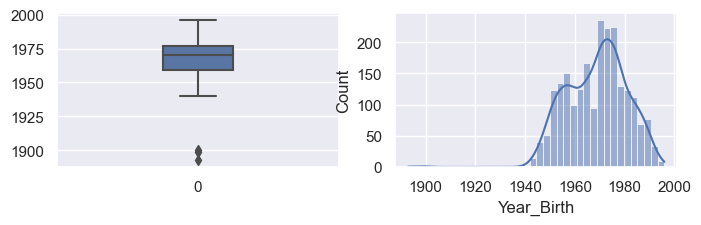

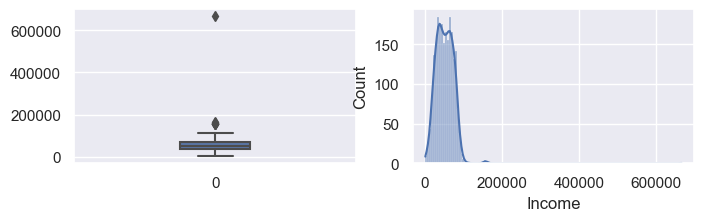

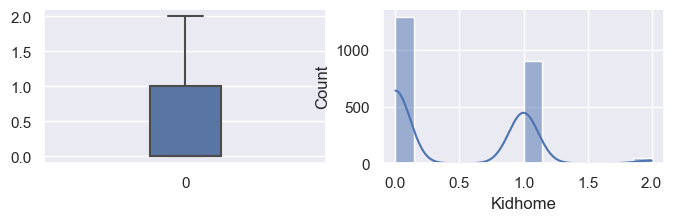

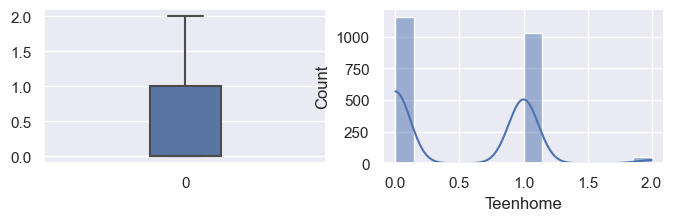

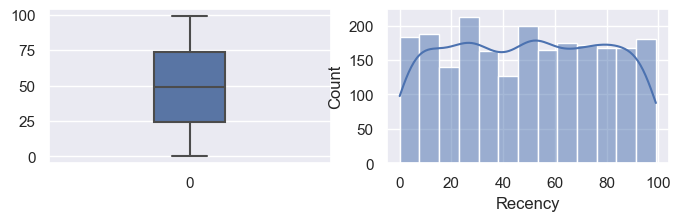

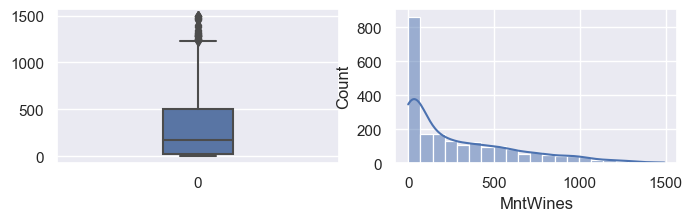

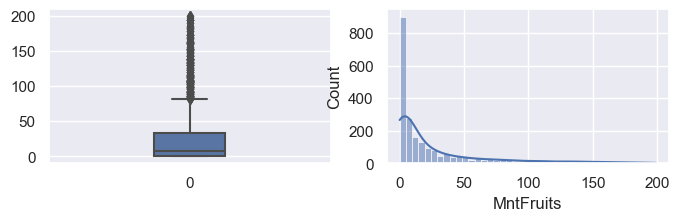

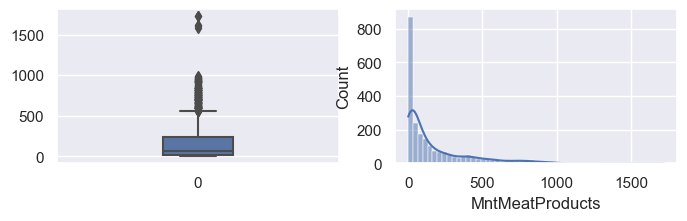

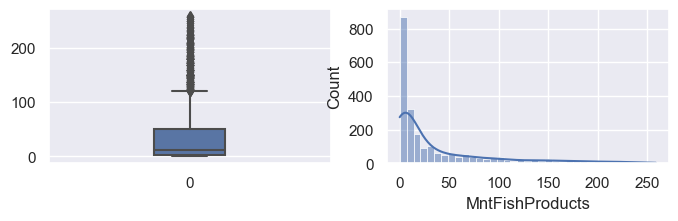

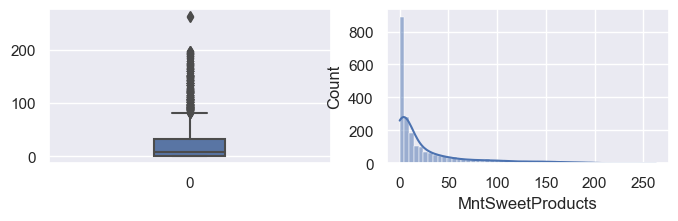

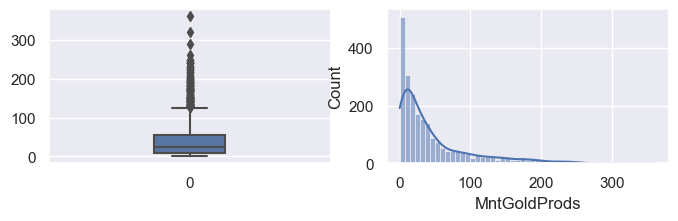

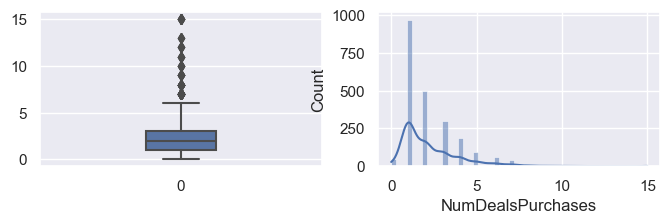

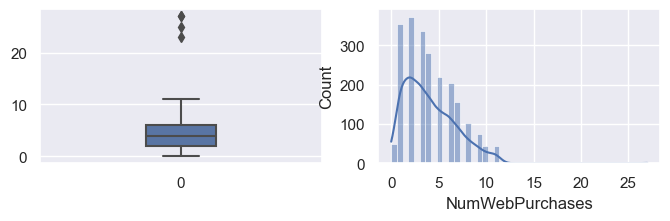

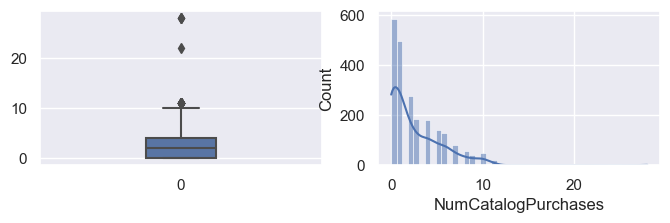

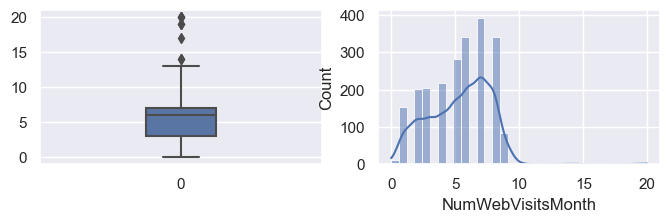

In [262]:
for var in var_numeriques:
    _, ax = plt.subplots(1, 2, figsize=(8, 2))
    sns.boxplot(df[var], width=0.25, ax=ax[0])
    sns.histplot(df[var], kde=True, ax=ax[1])
    plt.show()

In [263]:
# todo: commenter les distributions et boxplots

<Axes: >

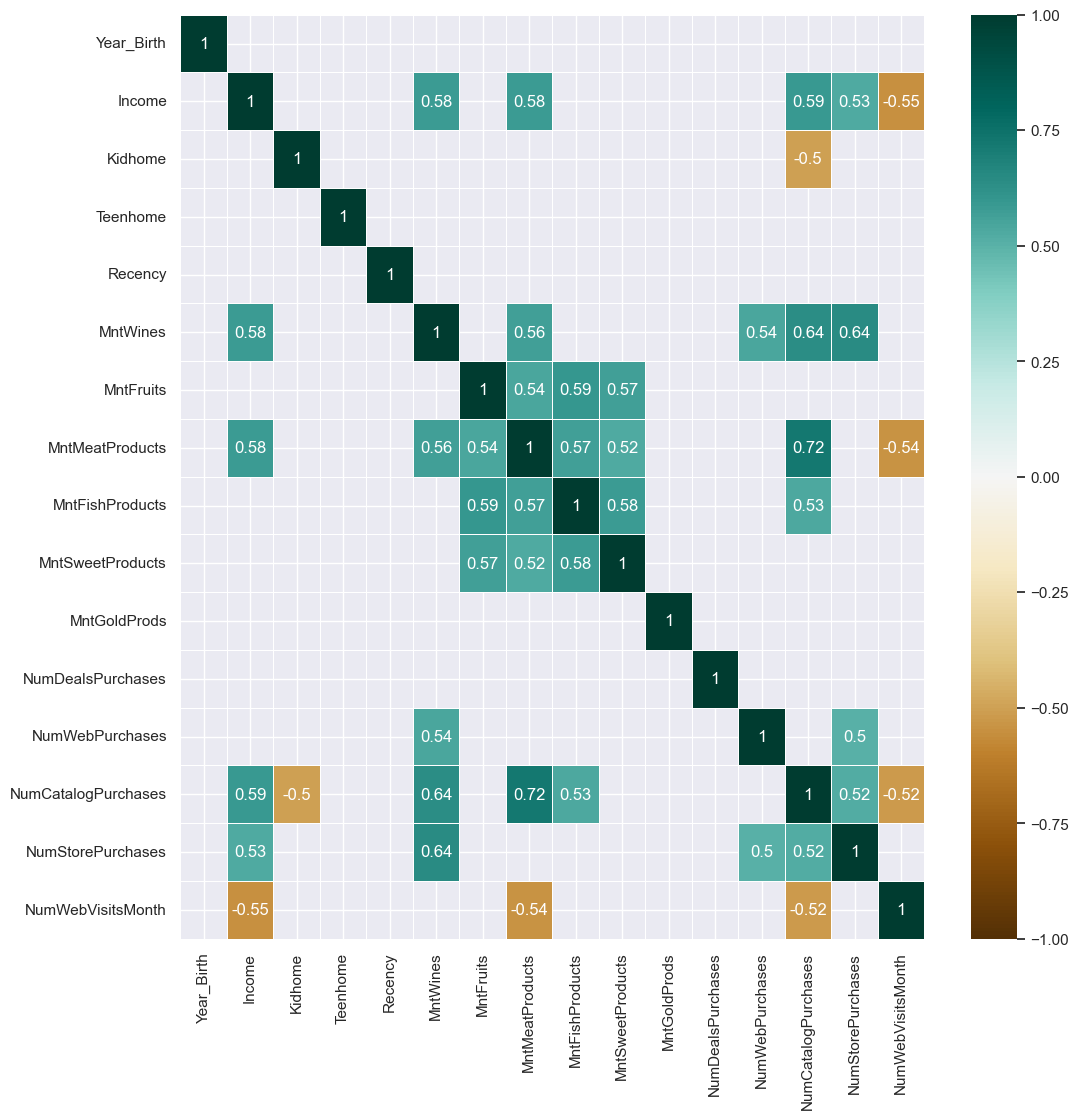

In [264]:
plt.figure(figsize=(12, 12))
sns.heatmap(
    df[var_numeriques].corr()[df[var_numeriques].corr().abs() > 0.5],
    annot=True,
    cmap="BrBG",
    linewidths=0.5,
    vmax=1,
    vmin=-1,
)

In [265]:
# todo: commenter la matrice de corrélation

<Axes: title={'center': 'Valeurs manquantes'}, ylabel='ID'>

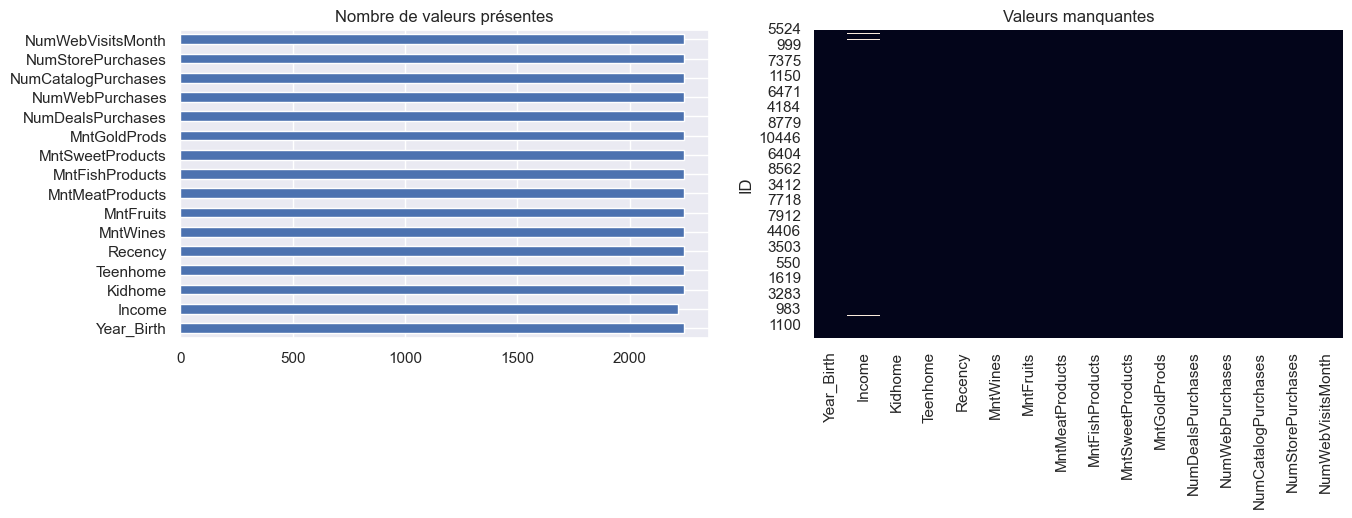

In [266]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].set_title("Nombre de valeurs présentes")
df.notna().sum()[var_numeriques].plot.barh(ax=ax[0])

ax[1].set_title("Valeurs manquantes")
sns.heatmap(df[var_numeriques].isna(), cbar=False, ax=ax[1])

Nous observons qu'il n'y a quasiment pas de valeurs manquantes parmi les variables numériques.

### Variables catégoriques

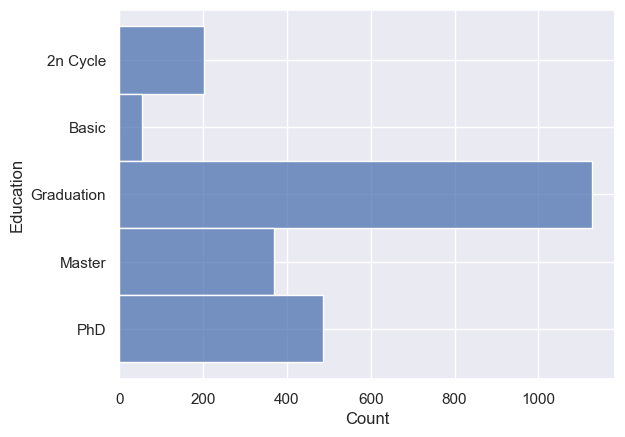

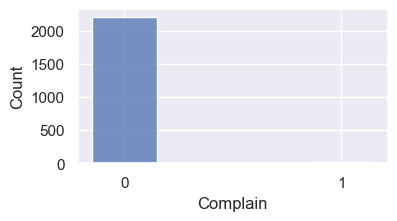

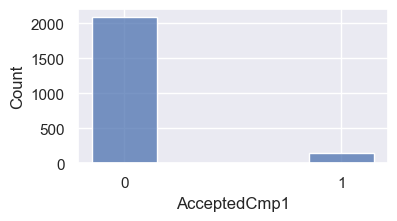

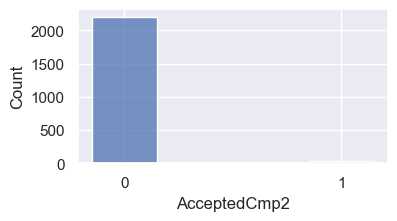

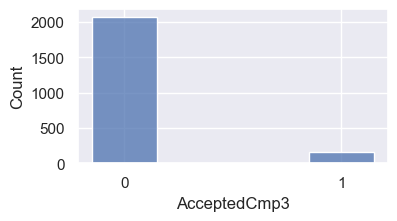

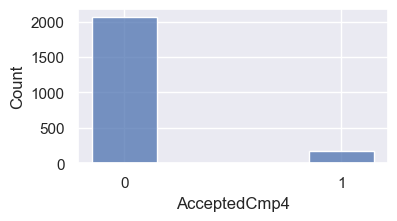

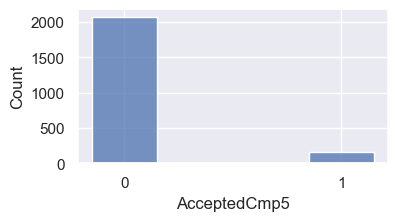

In [267]:
for var in var_categoriques:
    if df[var].nunique() > 3:
        sns.histplot(y=df[var])
    else:
        plt.figure(figsize=(4, 2))
        sns.histplot(df[var], shrink=0.3)
    plt.show()

In [268]:
df[
    df[var_categoriques].columns[df[var_categoriques].nunique() > 3]
].value_counts().plot(kind="bar")

<Axes: xlabel='Education,Marital_Status'>

In [269]:
# todo: commenter

In [270]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].set_title("Nombre de valeurs présentes")
df.notna().sum()[var_categoriques].plot.barh(ax=ax[0])

ax[1].set_title("Valeurs manquantes")
sns.heatmap(df[var_categoriques].isna(), cbar=False, ax=ax[1])

<Axes: title={'center': 'Valeurs manquantes'}, ylabel='ID'>

Nous observons l'absence de valeurs manquantes parmi les variables catégoriques.

### Dates

In [271]:
# todo

<Axes: >

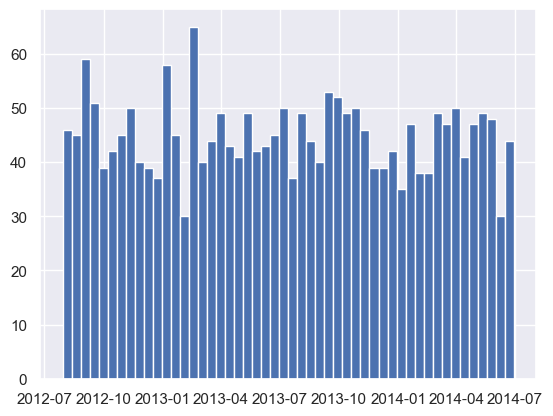

In [272]:
df["Dt_Customer"].hist(bins=50)

# Nettoyage des données

## Données parasites


### Variables

Dans le jeu de données, 2 colonnes sont non documentées et contiennent des valeurs constantes :
- `Z_CostContact`
- `Z_Revenue`

**Variable `Z_CostContact`**

In [273]:
print(
    f'Il y a {np.sum(df["Z_CostContact"] == 3)} / {len(df)} individus pour lesquelles la variable Z_CostContact vaut 3.'
)

Il y a 2240 / 2240 individus pour lesquelles la variable Z_CostContact vaut 3.


In [274]:
df["Z_CostContact"].hist()

<Axes: >

**Variable `Z_Revenue`**

In [275]:
print(
    f'Il y a {np.sum(df["Z_Revenue"] == 11)} / {len(df)} individus pour lesquelles la variable Z_Revenue vaut 11.'
)

Il y a 2240 / 2240 individus pour lesquelles la variable Z_Revenue vaut 11.


In [276]:
df["Z_Revenue"].hist()

<Axes: >

Nous décidons de les supprimer, car elles sont parasites et ne fournissent pas d'information.

In [277]:
df.drop(columns=["Z_CostContact", "Z_Revenue"], inplace=True)

### Valeurs

#### Statut marital

<Axes: xlabel='Count', ylabel='Marital_Status'>

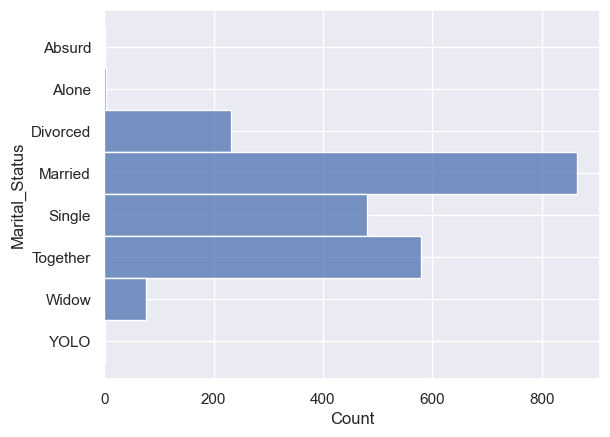

In [278]:
sns.histplot(y=df["Marital_Status"])

Parmi les situations maritales, on observe "absurde" et "YOLO" (You Only Live Once, _on ne vit qu'une fois_).

Comme on ne peut pas déduire ce que veut dire "absurde" dans ce contexte, on se décide de supprimer l'individu.
De même, on suppose que la personne ayant répondu "YOLO", donc ayant répondu de façon humoristique, doit être supprimée du jeu de données.

In [279]:
df.drop(index=df.loc[df["Marital_Status"] == "YOLO"].index, inplace=True)
df.drop(index=df.loc[df["Marital_Status"] == "Absurd"].index, inplace=True)

<Axes: xlabel='Count', ylabel='Marital_Status'>

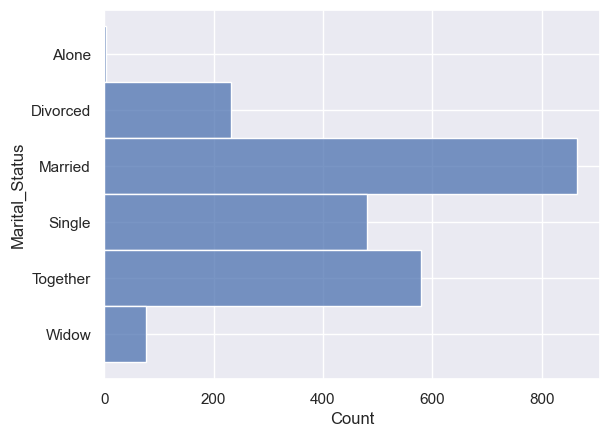

In [280]:
sns.histplot(y=df["Marital_Status"])

## Données dupliquées

### Individus

In [281]:
sum(df.duplicated())

182

Nous observons qu'il y a 182 lignes qui sont dupliquées.

Nous pouvons supposer que les données ont été fusionnées à partir de plusieurs sources, et que ces sources avaient des individus en commun : nous décidons donc de supprimer les doublons.

In [282]:
df.drop_duplicates(inplace=True)

In [283]:
sum(df.duplicated())

0

## Variables pas assez informatives

In [284]:
# todo: dire que la variable "Complain" (si le client s'est plaint ou non), n'apporte pas assez d'information pour être gardée, car il y a moins de 1% des observations qui ont une classe autre que "0", et qu'en plus ce n'est pas central à notre étude

In [285]:
# todo: essayer quand même une visualisation des individus s'étant plaint par rapport à nos variables cibles, au cas où...

In [286]:
sns.histplot(df["Complain"], shrink=0.5)

<Axes: xlabel='Complain', ylabel='Count'>

In [287]:
print(
    f'Il y a {100 * df["Complain"].astype(int).sum() / len(df["Complain"]):.2f}% des individus qui se sont plaints.'
)

Il y a 0.97% des individus qui se sont plaints.


## Standardisation

### Modalités de variables catégoriques

<Axes: xlabel='Count', ylabel='Marital_Status'>

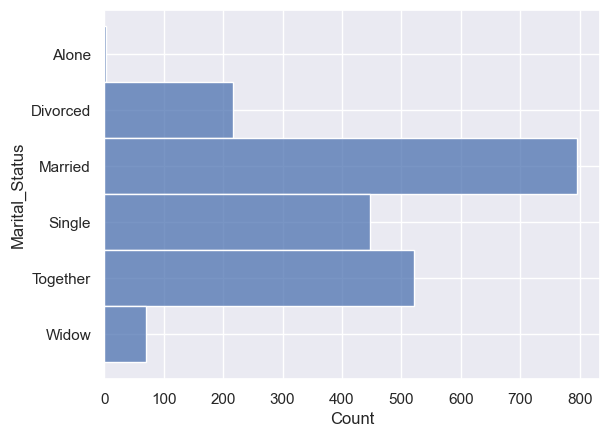

In [288]:
sns.histplot(y=df["Marital_Status"])

Sans plus d'information, "Alone" est une autre formulation de "Single", on décide donc de remplacer "Alone" par "Single".

In [289]:
df["Marital_Status"].replace("Alone", "Single", inplace=True)

<Axes: xlabel='Count', ylabel='Marital_Status'>

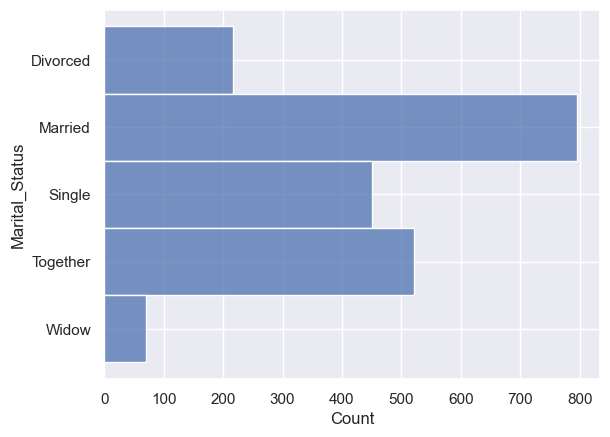

In [290]:
sns.histplot(y=df["Marital_Status"])

## Valeurs extrêmes

### Income

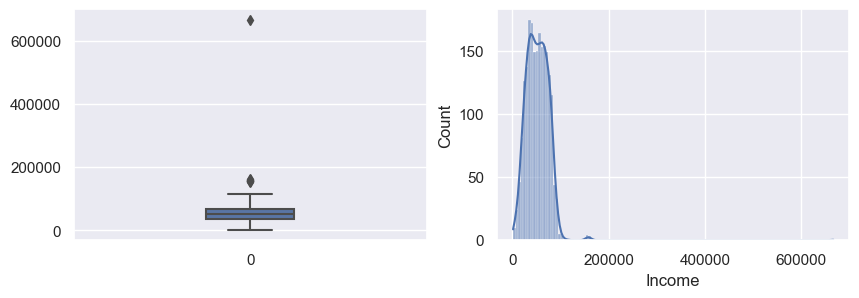

In [291]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(df["Income"], width=0.25, ax=ax[0])
sns.histplot(df["Income"], kde=True, ax=ax[1])
plt.show()

In [292]:
# todo: texte pour commenter

In [293]:
df["Income"][df["Income"] > 200_000]

ID
9432    666666.0
Name: Income, dtype: float64

Pour nous, il s'agit d'une valeur aberrante à supprimer du jeu de données car "666 666" ne semble pas être une valeur réelle (6 fois le nombre 6...).

In [294]:
df.drop(index=df[df["Income"] > 200_000].index, inplace=True)

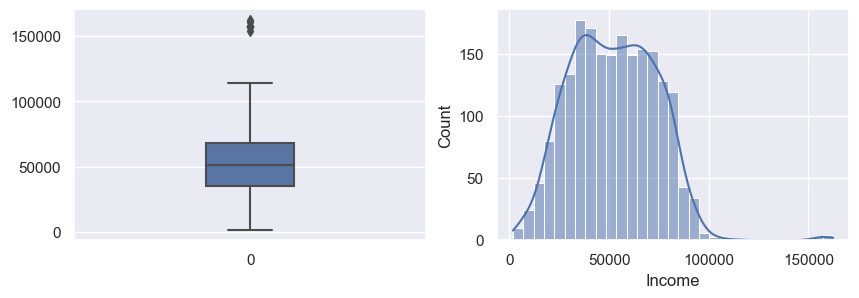

In [295]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(df["Income"], width=0.25, ax=ax[0])
sns.histplot(df["Income"], kde=True, ax=ax[1])
plt.show()

In [296]:
# todo: est-ce qu'on retire les valeurs au-dessus de 120 000 ? comment on le justifie ?
# => ce serait plutôt des individus ATYPIQUES, à enlever mais garder de côté pour l'analyse a posteriori

In [297]:
df.drop(index=df[df["Income"] > 120_000].index, inplace=True)

In [298]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(df["Income"], width=0.25, ax=ax[0])
sns.histplot(df["Income"], kde=True, ax=ax[1])
plt.show()

### Year Date

In [299]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(df["Year_Birth"], width=0.25, ax=ax[0])
sns.histplot(df["Year_Birth"], kde=True, ax=ax[1])
plt.show()

In [300]:
df[df["Year_Birth"] < 1920]

Year_Birth Education Marital_Status   Income  Kidhome  Teenhome  \
ID                                                                       
7829         1900  2n Cycle       Divorced  36640.0        1         0   
11004        1893  2n Cycle         Single  60182.0        0         1   
1150         1899       PhD       Together  83532.0        0         0   

      Dt_Customer  Recency  MntWines  MntFruits  ...  NumCatalogPurchases  \
ID                                               ...                        
7829   2013-09-26       99        15          6  ...                    1   
11004  2014-05-17       23         8          0  ...                    0   
1150   2013-09-26       36       755        144  ...                    6   

       NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
ID                                                                        
7829                   2                  5             0             0   
11004                  2                  4             0             0   
1150                   4                  1             0             0   

       AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain Response  
ID                                                                  
7829              0             0             0         1        0  
11004             0             0             0         0        0  
1150              1             0             0         0        0  

[3 rows x 26 columns]

Comme les personnes les plus âgées au monde ont très rarement plus de 100 ans, et que nous sommes en 2023, on peut sans problème estimer que les trois dates de naissance avant 1920 sont erronées.

Pour les deux années 1893 et 1899, on peut s'imaginer que les personnes ont fait une faute de frappe, et voulaient écrire, respectivement, 1983 et 1989.

In [301]:
df.loc[df["Year_Birth"] == 1893, "Year_Birth"] = 1983
df.loc[df["Year_Birth"] == 1899, "Year_Birth"] = 1989

Pour l'année 1900, il est difficile d'imaginer une faute de frappe, il s'agit peut-être de la valeur par défaut.
On peut tout simplement supprimer la ligne correspondante.

In [302]:
df.drop(index=df.loc[df["Year_Birth"] == 1900, "Year_Birth"].index, inplace=True)

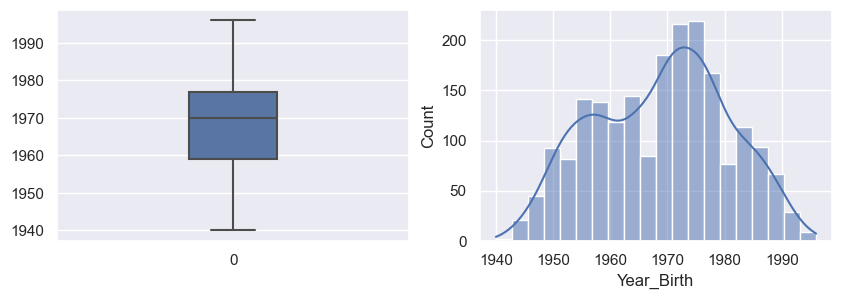

In [303]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(df["Year_Birth"], width=0.25, ax=ax[0])
sns.histplot(df["Year_Birth"], kde=True, ax=ax[1])
plt.show()

## Valeurs manquantes

<Axes: ylabel='ID'>

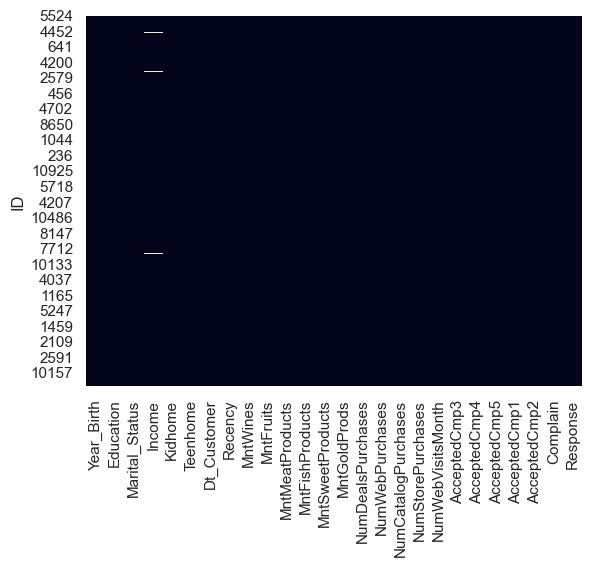

In [304]:
sns.heatmap(
    df.isna(), cbar=False
)  # todo: mettre les graphiques à côté (horizontalement)

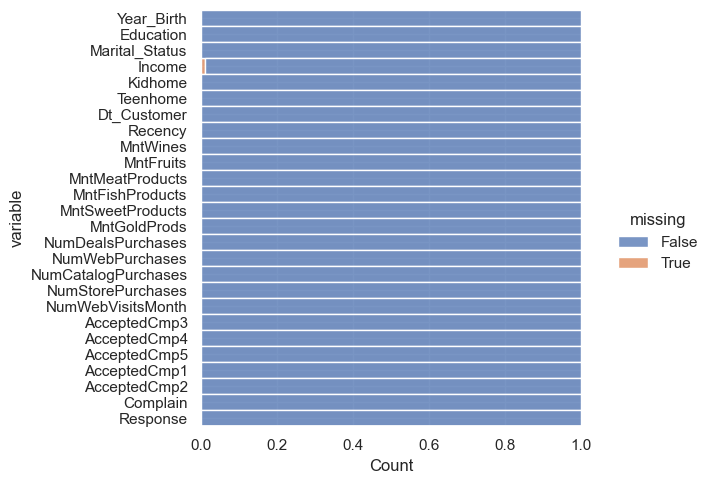

In [305]:
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25,
)

<Axes: title={'center': 'Nombre de valeurs manquantes pour chaque variable'}>

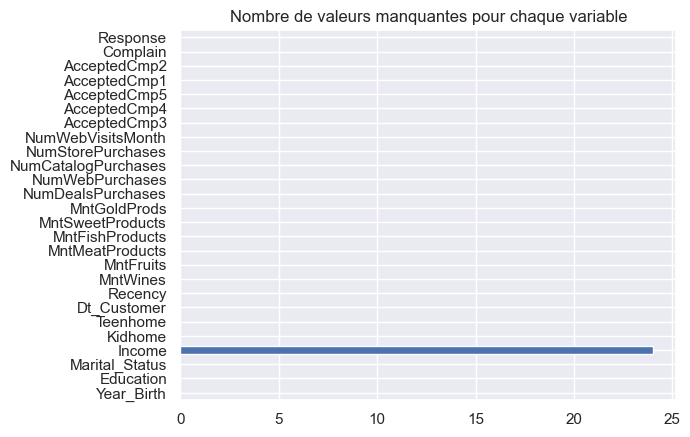

In [306]:
plt.title("Nombre de valeurs manquantes pour chaque variable")
df.isna().sum().plot.barh()

In [307]:
# todo : commenter

In [308]:
# TODO: supprimer valeurs manquantes OU remplacer par la moyenne ?

In [309]:
# todo: expliquer POURQUOI ces données sont manquantes (notre hypothèse du moins), et expliquer notre démarche en conséquence

### Remplacement par la moyenne

In [310]:
df["Income"][df["Income"].isna()]

ID
1994    NaN
5255    NaN
7281    NaN
7244    NaN
8557    NaN
10629   NaN
8996    NaN
9235    NaN
5798    NaN
8268    NaN
1295    NaN
2437    NaN
2863    NaN
10475   NaN
2902    NaN
4345    NaN
3769    NaN
7187    NaN
1612    NaN
5079    NaN
10339   NaN
3117    NaN
5250    NaN
8720    NaN
Name: Income, dtype: float64

In [311]:
df["Income"].fillna(df["Income"].mean(), inplace=True)

In [312]:
# Vérification du bon remplacement des valeurs manquantes
df["Income"].isna().sum()

0

# Création de variables

In [313]:
# todo : faire une var somme des achats sur le web
# todo : faire un client type par type d'achat (web / magasin) => est-ce que les gens qui achètent en web / magasin sont différents ?
# todo : créer une variable duréeClient qui dit depuis quand le client est inscrit

In [314]:
# todo: commenter la démarche

In [315]:
df["NbAcceptedCampaigns"] = 0

for i in range(1, 6):
    df["NbAcceptedCampaigns"] += df[f"AcceptedCmp{i}"].astype(int)

In [316]:
sns.histplot(df["NbAcceptedCampaigns"], discrete=True)

<Axes: xlabel='NbAcceptedCampaigns', ylabel='Count'>

In [317]:
df["HasAcceptedCampaigns"] = df["NbAcceptedCampaigns"] > 0

<Axes: xlabel='HasAcceptedCampaigns', ylabel='Count'>

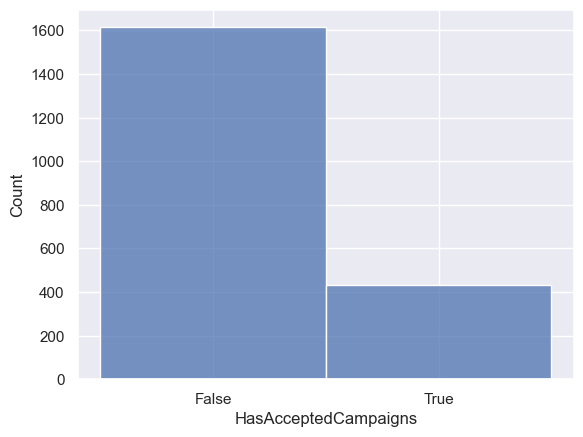

In [318]:
sns.histplot(df["HasAcceptedCampaigns"].astype(str))

In [319]:
df_clients = df[df["HasAcceptedCampaigns"]]
df_not_clients = df[~df["HasAcceptedCampaigns"]]

In [320]:
# todo: créer une variable qui additionne le nombre d'enfants Kids et Teen (mais avant cela, vérifier si par exemple Kids et Teen apportent des informations différentes => si les deux sont complémentaires, on les laisse / sinon on les supprime au profit de notre nouvelle variable)

<Axes: xlabel='Kidhome,Teenhome'>

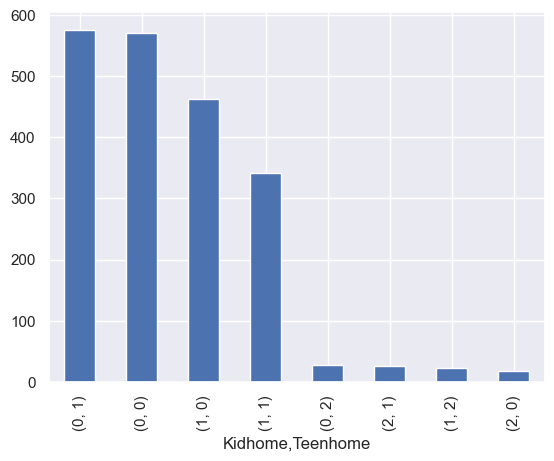

In [321]:
df[["Kidhome", "Teenhome"]].value_counts().plot(kind="bar")

In [322]:
df["NbChildren"] = df["Kidhome"] + df["Teenhome"]

In [323]:
sns.histplot(df["NbChildren"])

<Axes: xlabel='NbChildren', ylabel='Count'>

In [324]:
# todo: créer une variable "NbAcceptedCampaignsWithResponse", qui contient donc la 6ème campagne marketing => l'objectif est de clusteriser les gens en fonction de "à quel point ils sont marketables" => c'est-à-dire, on présente nos résultats en disant sur qui il vaut mieux se concentrer pour faire des pubs

In [325]:
# todo: créer une variable "RevenuePerClient" => le revenu rapporté par chaque client => ce serait plutôt juste une variable type "KPI" à afficher dans un dashboard non ?

In [326]:
# todo: de même, créer une variable "RevenueWinePerClient" => le revenu de vin pour chaque client, et faire de même pour chaque produit => par la suite on pourra faire des représentations "quel client rapporte le plus de vin"

# Visualisation

In [327]:
# todo: renommer cette partie ? / mettre un texte introductif pour expliquer la démarche ("Une fois les données nettoyées, on les explore de nouveau, plus en profondeur")

In [328]:
# todo: organiser en plusieurs sous-parties

In [329]:
# todo: choisir les représentations les plus pertinentes à montrer ci-dessous

In [330]:
sns.histplot(
    df,
    x="Income",
    hue="NbAcceptedCampaigns",
    kde=True,
    stat="density",
    common_norm=False,
)

<Axes: xlabel='Income', ylabel='Density'>

In [331]:
sns.histplot(
    df,
    x="Income",
    hue="NbAcceptedCampaigns",
    kde=True,
    stat="probability",
    common_norm=False,
)

<Axes: xlabel='Income', ylabel='Probability'>

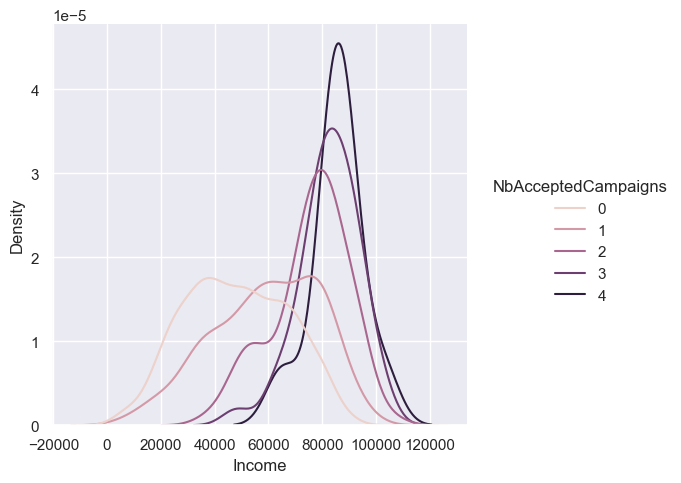

In [332]:
sns.displot(df, x="Income", hue="NbAcceptedCampaigns", kind="kde", common_norm=False)

In [333]:
# todo: faire la même chose en boxplots !

<Axes: xlabel='Income', ylabel='Count'>

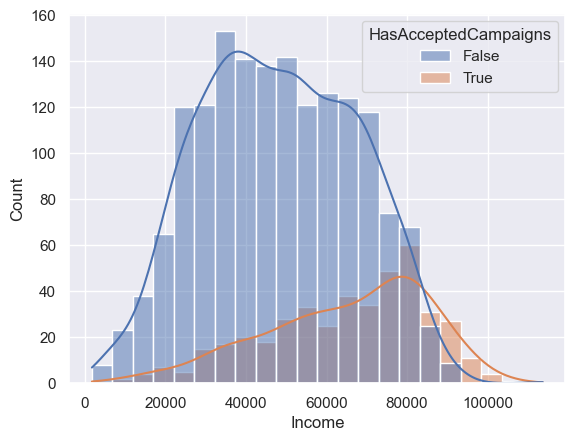

In [334]:
sns.histplot(df, x="Income", hue="HasAcceptedCampaigns", kde=True)

<Axes: xlabel='Income', ylabel='Count'>

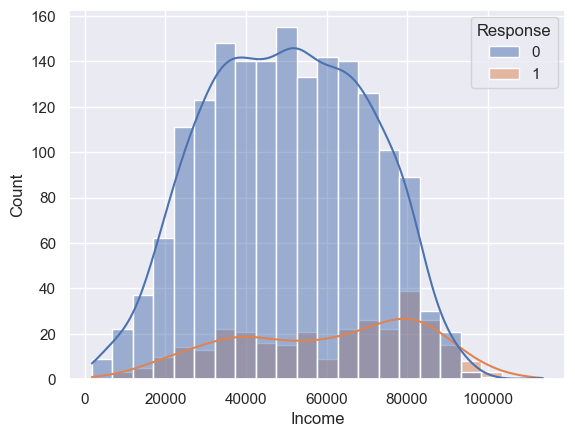

In [335]:
sns.histplot(df, x="Income", hue="Response", kde=True)

### Année naissance (test)

<Axes: xlabel='Year_Birth', ylabel='Count'>

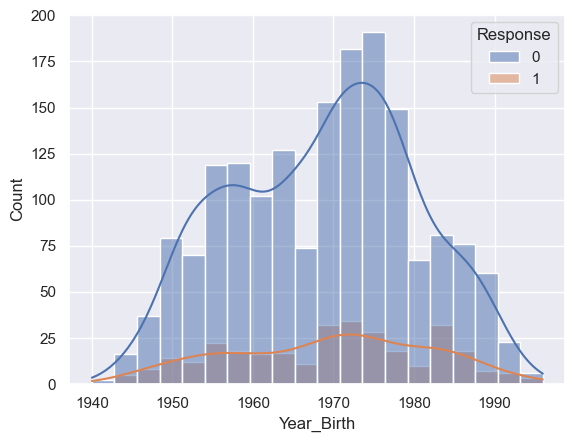

In [336]:
sns.histplot(df, x="Year_Birth", hue="Response", kde=True)

### todo

In [337]:
sns.histplot(
    data=df, x="Education", hue="HasAcceptedCampaigns", multiple="dodge", shrink=0.8
)

<Axes: xlabel='Education', ylabel='Count'>

<Axes: xlabel='NbChildren', ylabel='Count'>

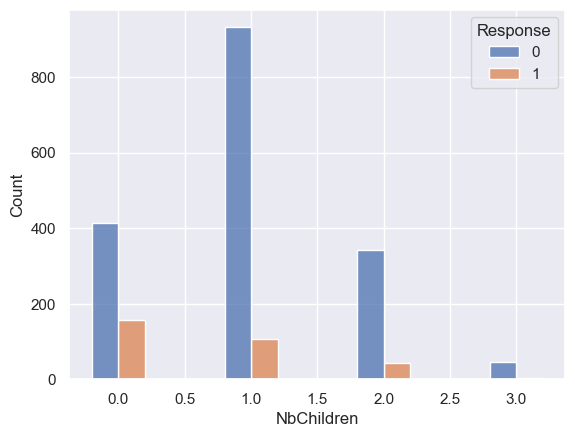

In [338]:
sns.histplot(
    data=df,
    x="NbChildren",
    hue="Response",
    multiple="dodge",
    discrete=True,
    shrink=0.4,
)

In [339]:
sns.histplot(
    data=df,
    x="NbChildren",
    hue="HasAcceptedCampaigns",
    multiple="dodge",
    discrete=True,
    shrink=0.4,
)

<Axes: xlabel='NbChildren', ylabel='Count'>

In [340]:
plt.figure(figsize=(12, 12))
sns.heatmap(
    df.corr()[df.corr().abs() > 0.5],
    annot=True,
    cmap="BrBG",
    linewidths=0.5,
    vmax=1,
    vmin=-1,
)

C:\Users\jules\AppData\Local\Temp\ipykernel_12628\1235220098.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()[df.corr().abs() > 0.5],


<Axes: >

## Régression polynomiale

### Premier exemple

In [341]:
sns.scatterplot(data=df, x="Income", y="MntWines", color="black")

<Axes: xlabel='Income', ylabel='MntWines'>

<Axes: xlabel='Income', ylabel='MntWines'>

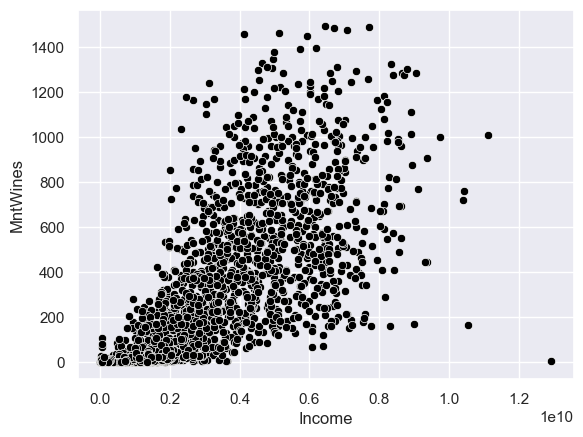

In [342]:
sns.scatterplot(x=df["Income"] ** 2, y=df["MntWines"], color="black")

<Axes: xlabel='Income', ylabel='MntWines'>

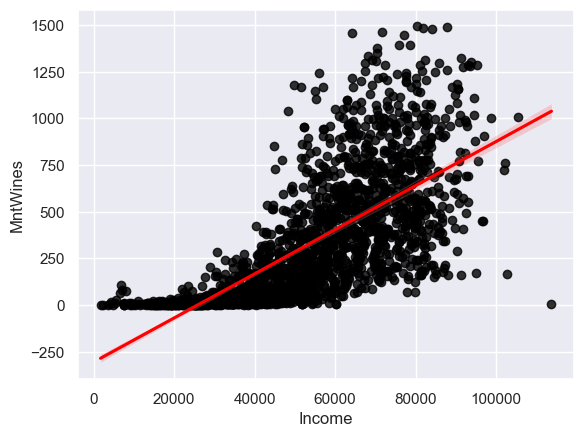

In [343]:
sns.regplot(
    x=df["Income"],
    y=df["MntWines"],
    scatter_kws={"color": "black"},
    line_kws={"color": "red"},
)

<Axes: xlabel='Income', ylabel='MntWines'>

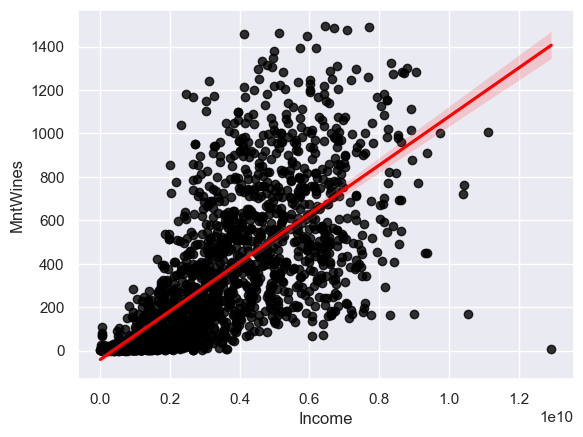

In [344]:
sns.regplot(
    x=df["Income"] ** 2,
    y=df["MntWines"],
    scatter_kws={"color": "black"},
    line_kws={"color": "red"},
)

In [345]:
sns.regplot(
    x=df["Income"] ** 3,
    y=df["MntWines"],
    scatter_kws={"color": "black"},
    line_kws={"color": "red"},
)

<Axes: xlabel='Income', ylabel='MntWines'>

### Afficher la courbe

In [346]:
# Régression linéaire basique
from sklearn.linear_model import LinearRegression

In [347]:
X = np.array(df[["Income"]] ** 2)
y = np.array(df[["MntWines"]])

In [348]:
reg = LinearRegression().fit(X, y)

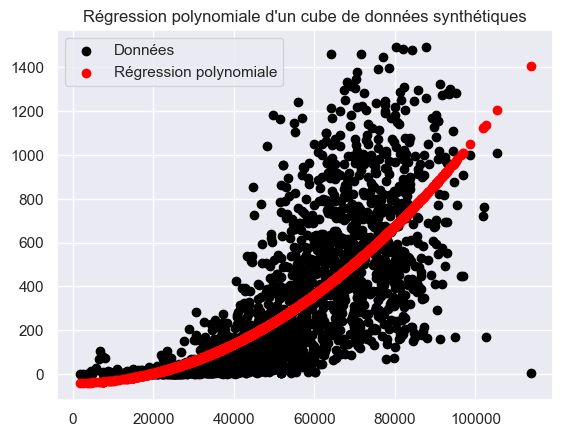

In [349]:
# Tracer les données et la courbe de régression polynomiale
plt.scatter(df["Income"], y, label="Données", color="black")
plt.scatter(df["Income"], reg.predict(X), label="Régression polynomiale", color="red")

plt.legend(loc="best")
plt.title("Régression polynomiale d'un cube de données synthétiques")

plt.show()

### Polynomial Features

In [350]:
# Pour la régression polynomiale
from sklearn.preprocessing import PolynomialFeatures

In [351]:
# Transformer les données en matrice de caractéristiques polynomiales
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

Si on donne une variable $V$, PolynomialFeatures crée les variables
- $1$
- $V$
- $V^2$

Si on donne les variables $V$ et $W$, PolynomialFeatures crée les variables
- $1$
- $V$
- $W$
- $V \times W$
- $V^2$
- $W^2$

(attention à l'explosion combinatoire du nombre de variables !)

In [352]:
# Entraîner un modèle de régression linéaire sur les données transformées
reg = LinearRegression().fit(X_poly, y)

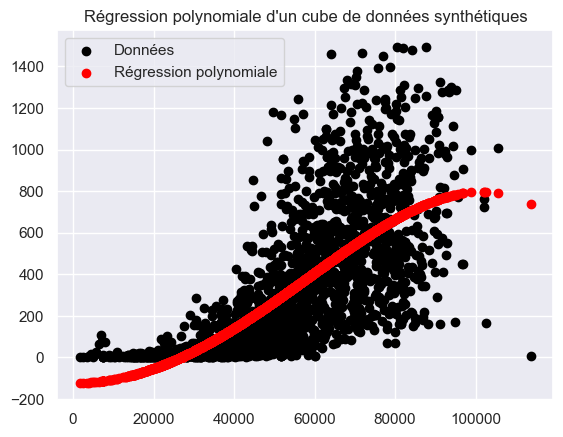

In [353]:
# Tracer les données et la courbe de régression polynomiale
plt.scatter(df["Income"], y, label="Données", color="black")
plt.scatter(
    df["Income"], reg.predict(X_poly), label="Régression polynomiale", color="red"
)

plt.legend(loc="best")
plt.title("Régression polynomiale d'un cube de données synthétiques")

plt.show()

### Attention au sur-apprentissage

In [354]:
# Transformer les données en matrice de caractéristiques polynomiales
poly = PolynomialFeatures(degree=10)
X_poly = poly.fit_transform(X)

In [355]:
# Entraîner un modèle de régression linéaire sur les données transformées
reg = LinearRegression().fit(X_poly, y)

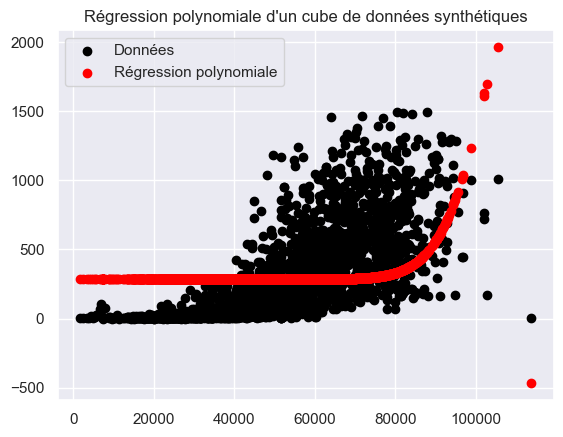

In [356]:
# Tracer les données et la courbe de régression polynomiale
plt.scatter(df["Income"], y, label="Données", color="black")
plt.scatter(
    df["Income"], reg.predict(X_poly), label="Régression polynomiale", color="red"
)

plt.legend(loc="best")
plt.title("Régression polynomiale d'un cube de données synthétiques")

plt.show()

## todo

<Axes: xlabel='Income', ylabel='MntMeatProducts'>

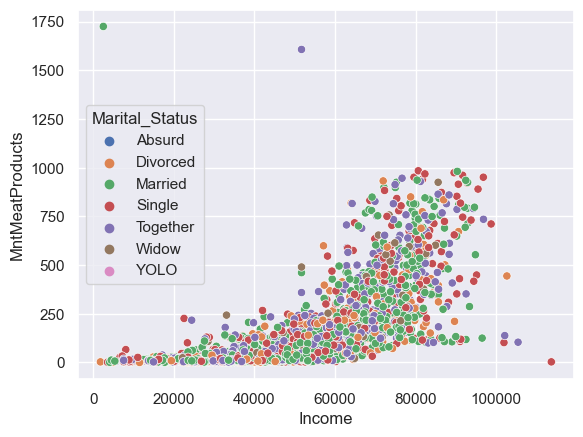

In [357]:
sns.scatterplot(data=df, x="Income", y="MntMeatProducts", hue="Marital_Status")

In [358]:
sns.scatterplot(data=df, x="Income", y="MntWines")

<Axes: xlabel='Income', ylabel='MntWines'>

<Axes: xlabel='Education', ylabel='Count'>

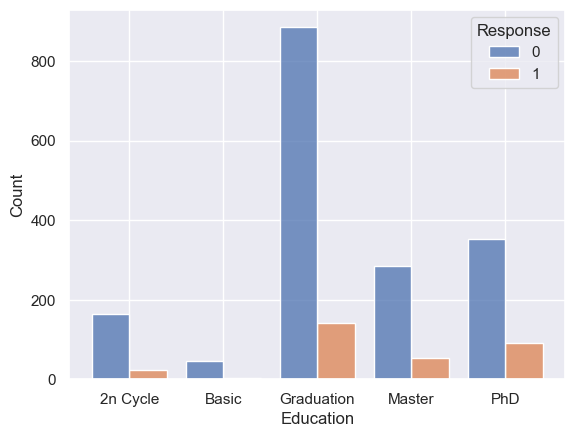

In [359]:
sns.histplot(data=df, x="Education", hue="Response", multiple="dodge", shrink=0.8)

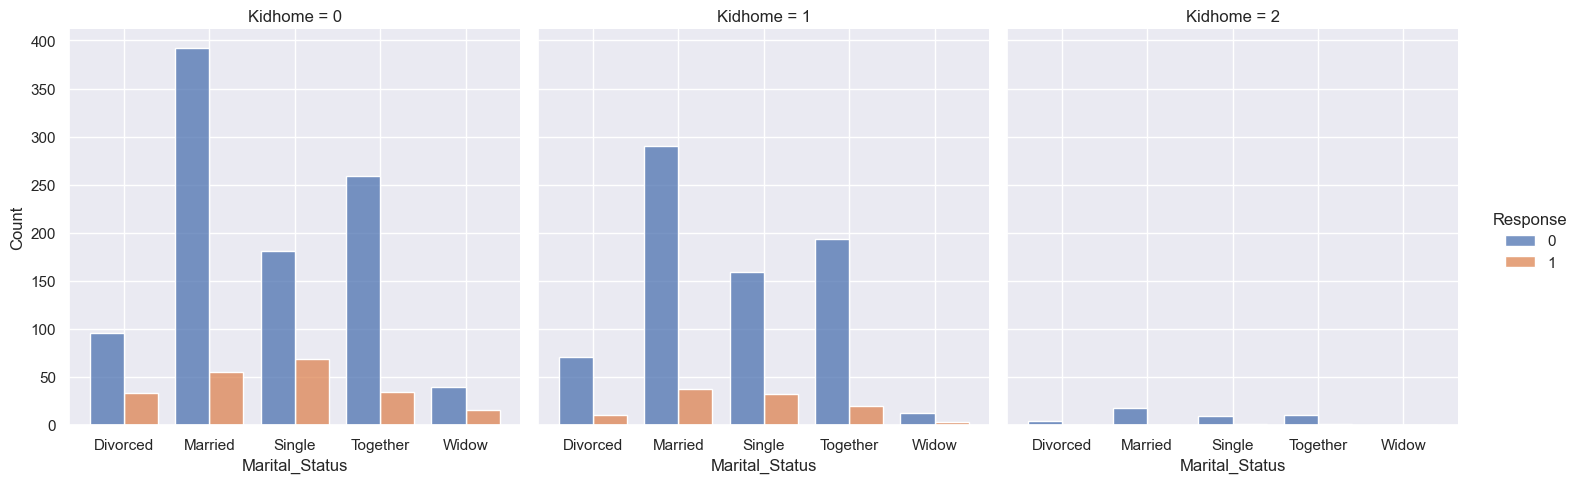

In [360]:
sns.displot(
    data=df,
    x="Marital_Status",
    hue="Response",
    col="Kidhome",
    multiple="dodge",
    shrink=0.8,
)

# Tests d'hypothèse

## ANOVA

### Problématique

Nous allons tester l'indépendance entre la variable `Response` (catégorique, binaire) et `Income` (quantitative continue), pour répondre à la question : "le revenu influence-t-il la réponse aux campagnes marketing ?".

<Axes: xlabel='Income', ylabel='Response'>

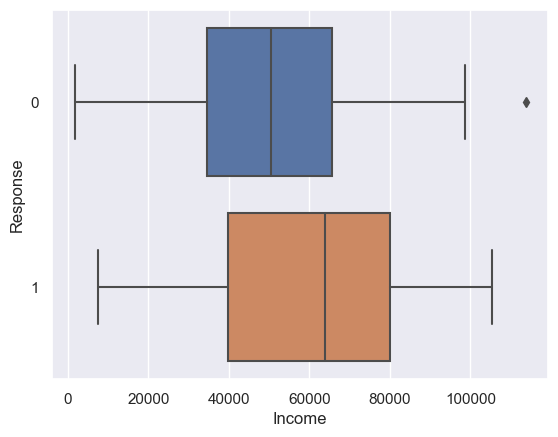

In [361]:
sns.boxplot(df, x="Income", y="Response")

On cherche à déterminer si les moyennes des groupes sont significativement différentes. On pose donc :

$H_0$ : Les moyennes de chaque groupe sont égales si la p-value $> 5\%$
$H_1$ : Les moyennes de chaque groupe ne sont pas toutes égales si la p-value $< 5\%$


### Hypothèses

1) l’indépendance entre les échantillons de chaque groupe
2) l’égalité des variances que l’on peut verifier avec un test de Bartlett.
3) la normalité des résidus avec un test de Shapiro.

#### Indépendance

#### Egalité des variances

In [362]:
from scipy.stats import bartlett

Voici la variance de chaque groupe :

In [363]:
df.groupby("Response")["Income"].agg("var")

Response
0    3.895393e+08
1    5.353886e+08
Name: Income, dtype: float64

Nous allons effectuer un test de Bartlett pour vérifier l'égalité des variances.

$H_0$ : Les variances de chaque groupe sont égales si p-value $> 5\%$
$H_1$ : Les variances de chaque groupe ne sont pas toutes égales $< 5\%$


In [364]:
bartlett(
    df["Income"][df["Response"] == "0"],
    df["Income"][df["Response"] == "1"],
)

BartlettResult(statistic=14.286824958954083, pvalue=0.0001569596411630625)

Notre p-value est inférieure à 5%, donc les variances ne sont pas toutes égales au (risque de 5%).

#### Normalité des résidus

Nous utilisons le test de Shapiro-Wilk pour vérifier la normalité des résidus.

H0 : Les résidus suivent une loi normale si p-value > 5%
H1 : Les résidus ne suivent pas une loi normale si p-value < 5%

In [365]:
from scipy.stats import shapiro
from statsmodels.formula.api import ols

model = ols("Income ~ Response", data=df).fit()
shapiro(model.resid)

ShapiroResult(statistic=0.9858090281486511, pvalue=2.2619989106624494e-13)

Comme la p-value est inférieure à 5%, les résidus ne suivent pas une loi normale (au risque de 5%).

#### Test d'ANOVA

H0 : Les moyennes de chaque groupe sont égales si p-value > 5%
H1 : Les moyennes de chaque groupe ne sont pas toutes égales < 5%

In [366]:
import statsmodels.api as sm

anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq      df          F        PR(>F)
Response  2.603158e+10     1.0  63.234078  3.009743e-15
Residual  8.410420e+11  2043.0        NaN           NaN

Comme aucune hypothèse n'est vérifiée, le test n'est pas fiable.

In [367]:
# todo: tenter le GLS

# Transformation des données

In [368]:
df_transforme = df.copy()

## Mise à l'échelle (réduction ?)

### Explication

In [369]:
# todo: expliquer pourquoi on a envie de le faire

### Sélection des variables

In [370]:
df[var_numeriques].hist(figsize=(12, 12), bins=30)
plt.show()

In [371]:
# todo(prof): est-ce que notre choix de variables est bon ?
var_a_scaler = [
    "Year_Birth",
    "Income",
    "Recency",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
]

<Axes: >

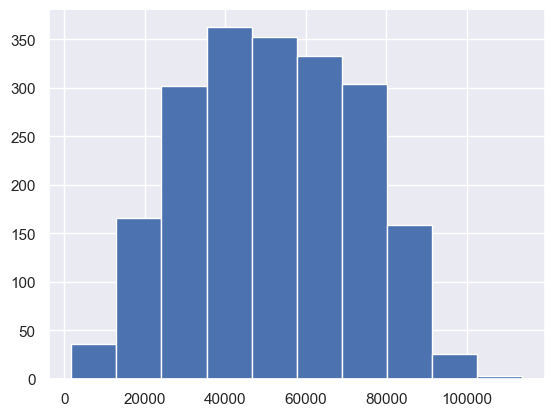

In [372]:
df["Income"].hist()

<Axes: >

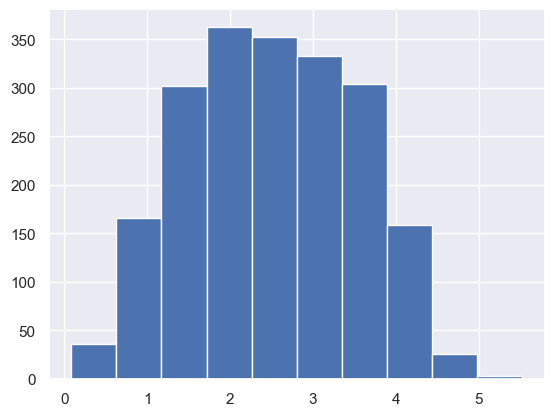

In [373]:
(df["Income"] / df["Income"].std()).hist()

### Transformation

In [374]:
for var in var_a_scaler:
    df_transforme[var] = df[var] / df[var].std()
    df_transforme[var] -= df_transforme[var].min()

### Conclusion

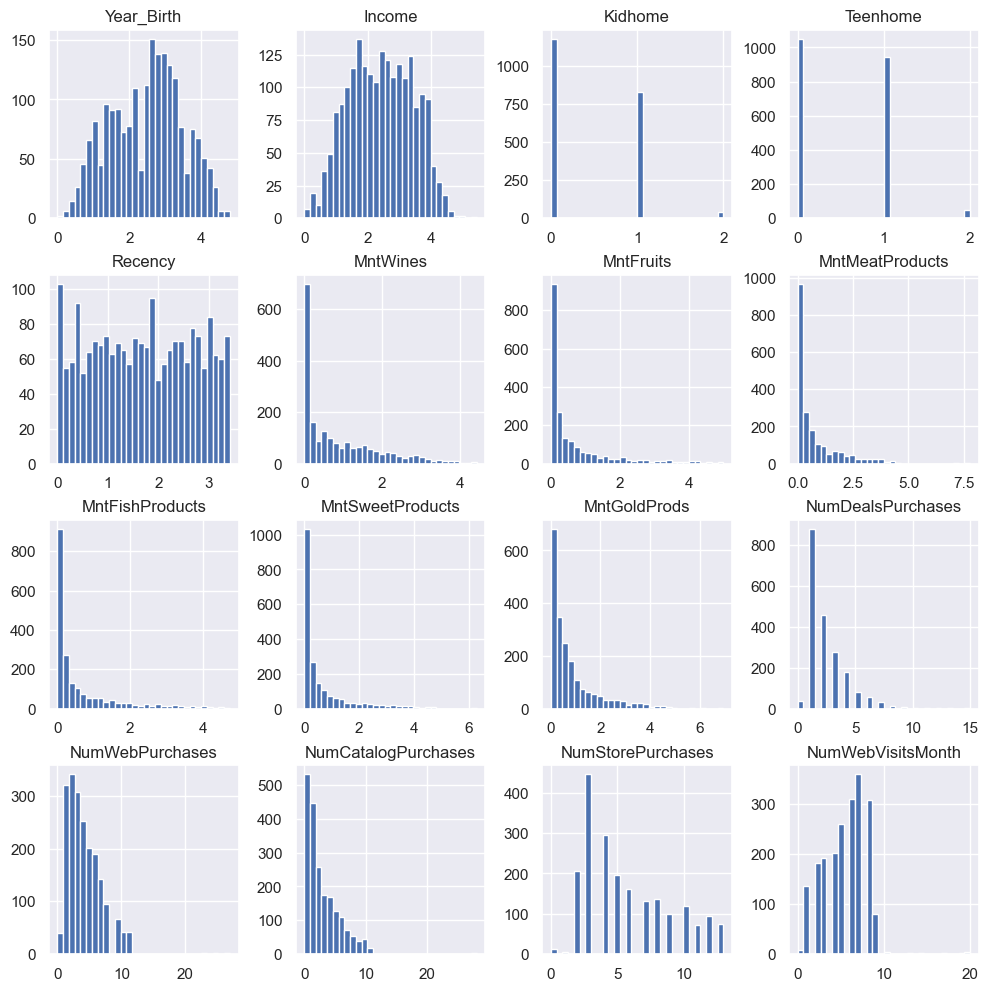

In [375]:
df_transforme[var_numeriques].hist(figsize=(12, 12), bins=30)
plt.show()

Les changements sur la matrice de corrélation sont de l'ordre de $10^{-15}$, donc extrêmement négligeables.

<Axes: >

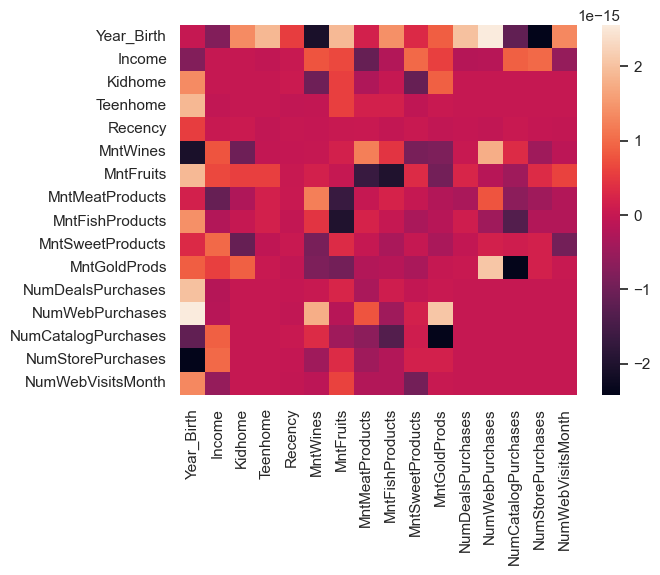

In [376]:
sns.heatmap(df_transforme[var_numeriques].corr() - df[var_numeriques].corr())

## Normalisation

### Explication

Pour normaliser les données, nous allons utiliser la transformation de Box-Cox, définie $\forall x > 0, $ comme ci-dessous :
$B(x, \lambda) = \begin{cases} \frac{x^{\lambda} - 1}{\lambda} & \text{  si } \lambda \neq 0 \\ \log(x) & \text{  si } \lambda = 0 \end{cases}$

Cette transformation est à appliquer à une variable (strictement positive), en ajustant le $\lambda$ pour maximiser la normalité.

Nous allons utiliser la librairie `scipy.stats.boxcox` qui estime le meilleur paramètre $\lambda$.

### Sélection des variables

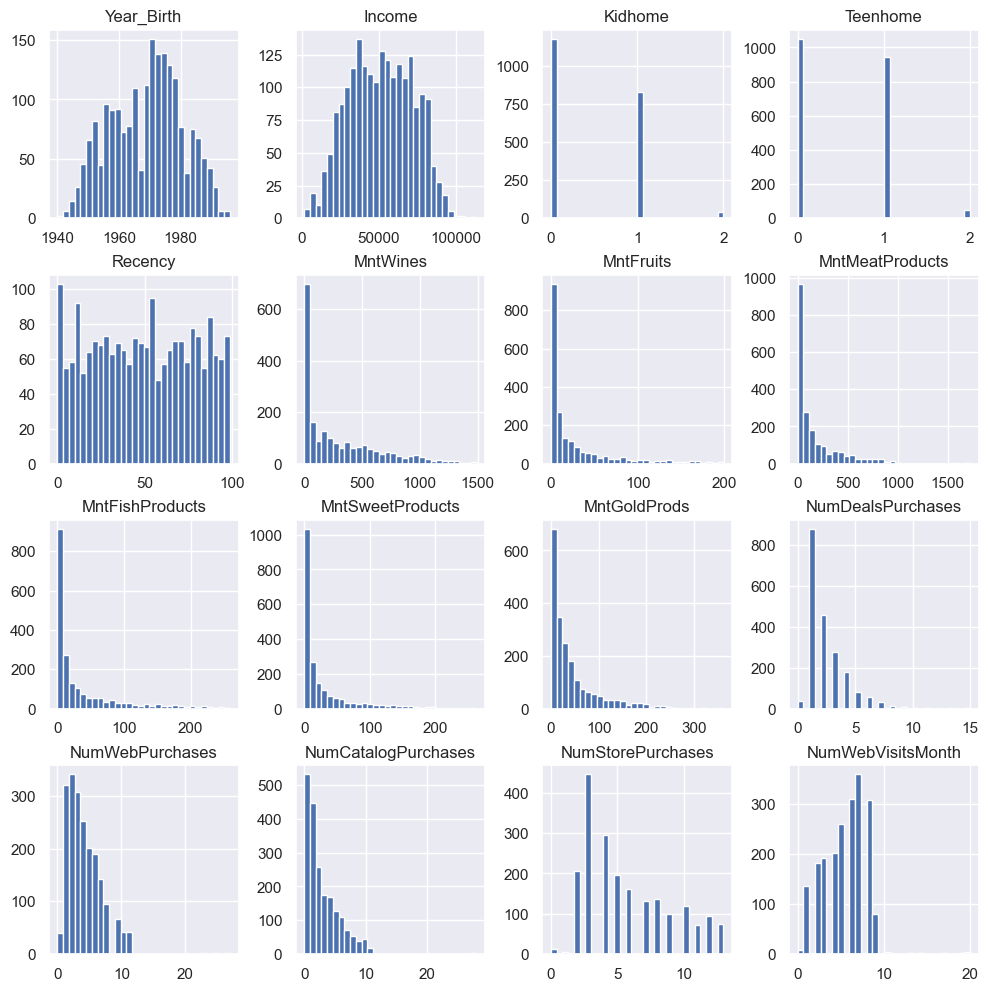

In [377]:
df[var_numeriques].hist(figsize=(12, 12), bins=30)
plt.show()

In [378]:
# todo(prof): faut-il inclure la distribution uniforme Recency ?
# todo(prof): est-ce que notre choix de variables est bon ?
var_a_normaliser = [
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
]

### Transformation

<Axes: xlabel='MntWines', ylabel='Count'>

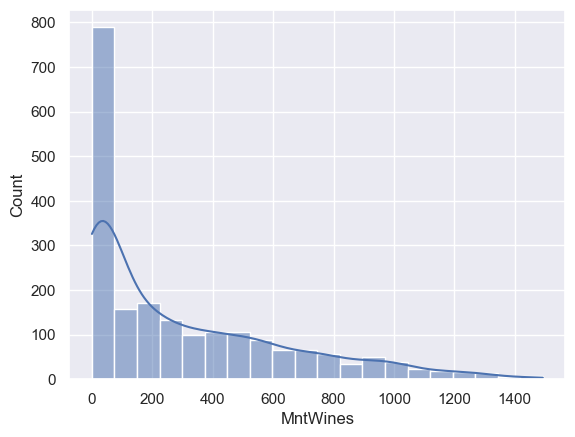

In [379]:
sns.histplot(df["MntWines"], kde=True)

In [380]:
from scipy.stats import boxcox

In [381]:
boxcox_lambdas = {}  # on garde les lambdas, pour la transformation inverse

In [382]:
for var in var_a_normaliser:
    var_strict_positif = df[var] + df[var].min() + 1

    var_apres_boxcox, l = boxcox(var_strict_positif)

    df_transforme[var] = var_apres_boxcox
    boxcox_lambdas[var] = l

In [383]:
# Tuto : comment récupérer la fonction initiale
# (il faut avoir récupéré le paramètre "l" lambda)

# from scipy.special import inv_boxcox
# initial = inv_boxcox(incbox, l)
# initial = pd.DataFrame(initial)
# sns.histplot(initial, bins=50, kde=True)

<Axes: xlabel='MntWines', ylabel='Count'>

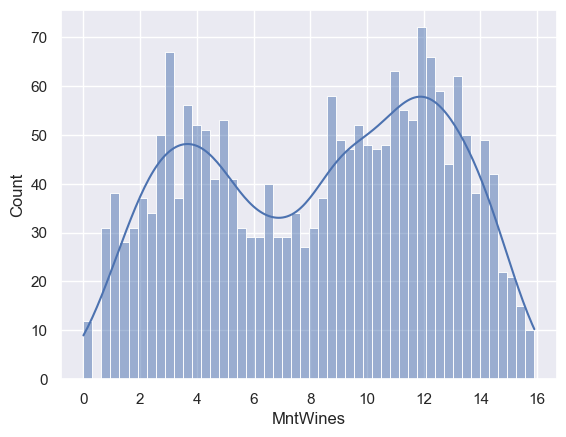

In [384]:
sns.histplot(df_transforme["MntWines"], bins=50, kde=True)

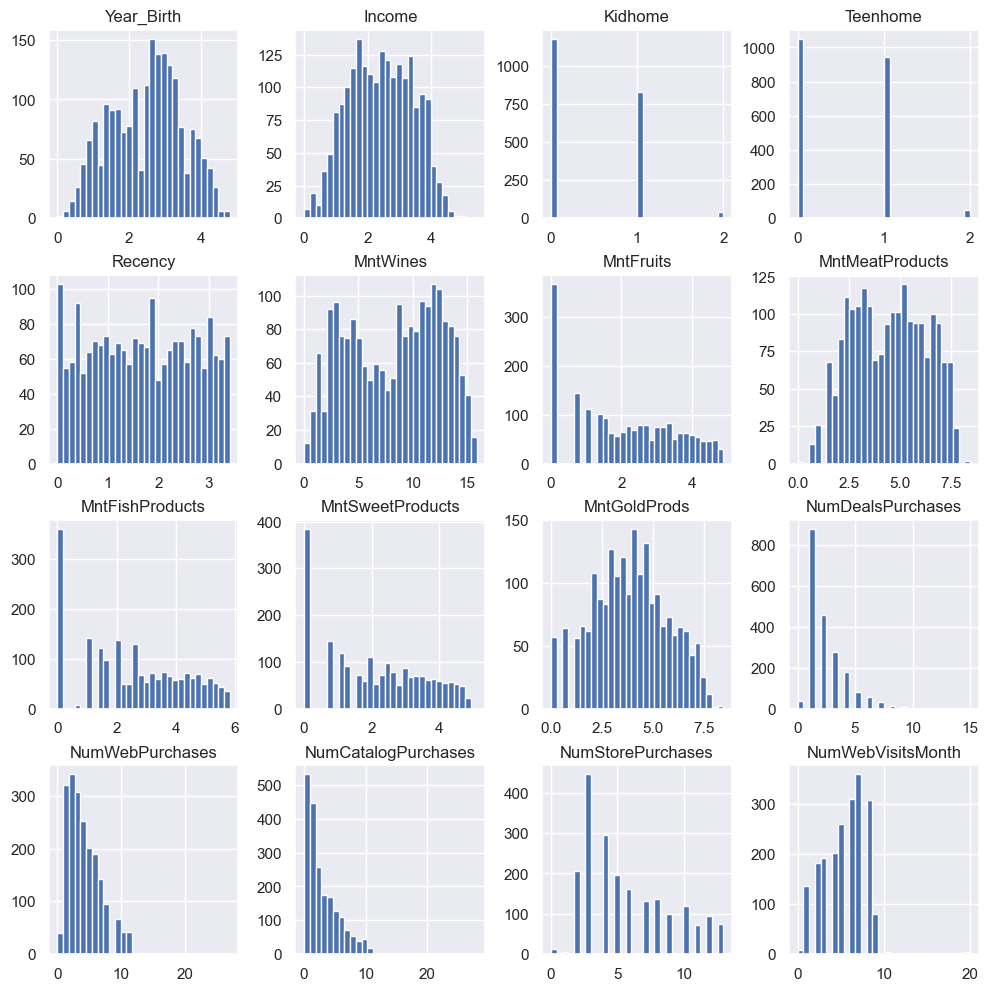

In [385]:
df_transforme[var_numeriques].hist(figsize=(12, 12), bins=30)
plt.show()

### Conclusion

In [386]:
# todo: analyser les résultats, notamment l'impact sur la matrice de corrélation (du coup, mettre ci-dessous la matrice de corrélation pré-transformation et comparer)

<Axes: >

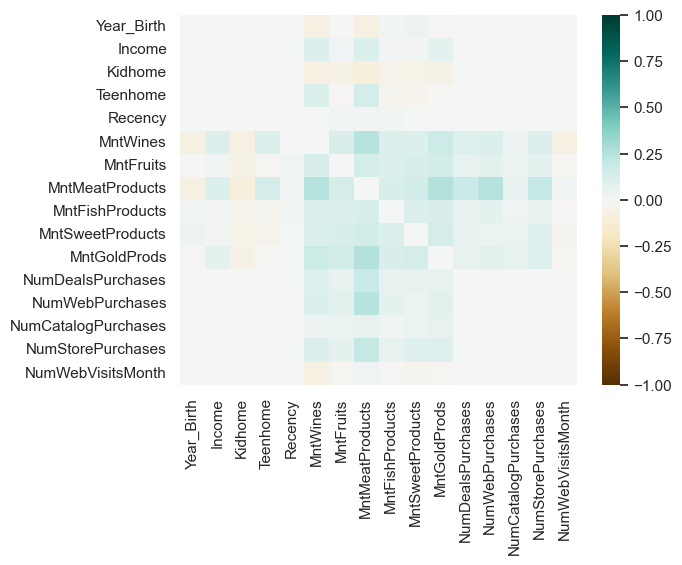

In [387]:
sns.heatmap(
    df_transforme[var_numeriques].corr() - df[var_numeriques].corr(),
    cmap="BrBG",
    vmin=-1,
    vmax=1,
)

In [388]:
df_transforme[var_numeriques].corr() - df[var_numeriques].corr()

Year_Birth        Income       Kidhome      Teenhome  \
Year_Birth           0.000000e+00 -7.771561e-16  1.360023e-15  1.887379e-15   
Income              -7.771561e-16  0.000000e+00  0.000000e+00 -5.551115e-17   
Kidhome              1.360023e-15  0.000000e+00  0.000000e+00  0.000000e+00   
Teenhome             1.887379e-15 -5.551115e-17  0.000000e+00  0.000000e+00   
Recency              5.447032e-16  2.591243e-17  6.591949e-17 -6.245005e-17   
MntWines            -7.469778e-02  1.083924e-01 -7.681926e-02  1.167555e-01   
MntFruits           -3.218793e-03  3.085872e-02 -6.443844e-02 -1.524028e-02   
MntMeatProducts     -7.282707e-02  1.146287e-01 -9.567407e-02  1.401372e-01   
MntFishProducts      2.082982e-02  9.607855e-03 -4.372404e-02 -2.412043e-02   
MntSweetProducts     3.230423e-02  1.227244e-02 -5.405729e-02 -3.651175e-02   
MntGoldProds        -9.066352e-03  7.352316e-02 -6.189934e-02 -3.120371e-03   
NumDealsPurchases    1.998401e-15 -1.942890e-16  0.000000e+00  0.000000e+00   
NumWebPurchases      2.553513e-15 -1.665335e-16  0.000000e+00  0.000000e+00   
NumCatalogPurchases -1.165734e-15  8.881784e-16  0.000000e+00  0.000000e+00   
NumStorePurchases   -2.414735e-15  9.992007e-16  0.000000e+00  0.000000e+00   
NumWebVisitsMonth    1.318390e-15 -5.551115e-16  0.000000e+00  0.000000e+00   

                          Recency  MntWines  MntFruits  MntMeatProducts  \
Year_Birth           5.447032e-16 -0.074698  -0.003219        -0.072827   
Income               2.591243e-17  0.108392   0.030859         0.114629   
Kidhome              6.591949e-17 -0.076819  -0.064438        -0.095674   
Teenhome            -6.245005e-17  0.116755  -0.015240         0.140137   
Recency              0.000000e+00  0.003093   0.029431         0.011562   
MntWines             3.093393e-03  0.000000   0.123121         0.249256   
MntFruits            2.943101e-02  0.123121   0.000000         0.143620   
MntMeatProducts      1.156153e-02  0.249256   0.143620         0.000000   
MntFishProducts      1.645091e-02  0.115089   0.103626         0.126062   
MntSweetProducts     3.659542e-03  0.117157   0.127451         0.151080   
MntGoldProds         4.720483e-03  0.178009   0.154503         0.252524   
NumDealsPurchases   -1.821460e-17  0.100588   0.064416         0.191481   
NumWebPurchases     -6.418477e-17  0.114578   0.084931         0.246149   
NumCatalogPurchases  3.469447e-17  0.038455   0.044845         0.058533   
NumStorePurchases   -1.452831e-17  0.105515   0.075335         0.207125   
NumWebVisitsMonth   -2.949030e-17 -0.075004  -0.018860         0.030879   

                     MntFishProducts  MntSweetProducts  MntGoldProds  \
Year_Birth                  0.020830          0.032304     -0.009066   
Income                      0.009608          0.012272      0.073523   
Kidhome                    -0.043724         -0.054057     -0.061899   
Teenhome                   -0.024120         -0.036512     -0.003120   
Recency                     0.016451          0.003660      0.004720   
MntWines                    0.115089          0.117157      0.178009   
MntFruits                   0.103626          0.127451      0.154503   
MntMeatProducts             0.126062          0.151080      0.252524   
MntFishProducts             0.000000          0.112125      0.122423   
MntSweetProducts            0.112125          0.000000      0.147159   
MntGoldProds                0.122423          0.147159      0.000000   
NumDealsPurchases           0.068902          0.061258      0.058671   
NumWebPurchases             0.077189          0.039283      0.078229   
NumCatalogPurchases         0.024266          0.043287      0.059180   
NumStorePurchases           0.067400          0.093222      0.096160   
NumWebVisitsMonth          -0.013253         -0.024093     -0.017537   

                     NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
Year_Birth                1.998401e-15     2.553513e-15        -1.165734e-15   
Income            

In [389]:
plt.figure(figsize=(12, 12))
plt.title("Matrice de corrélation des variables numériques avant transformation")
sns.heatmap(
    df[var_numeriques].corr()[df[var_numeriques].corr().abs() > 0.5],
    annot=True,
    cmap="BrBG",
    linewidths=0.5,
    vmax=1,
    vmin=-1,
)

<Axes: title={'center': 'Matrice de corrélation des variables numériques avant transformation'}>

<Axes: title={'center': 'Matrice de corrélation des variables numériques après transformation'}>

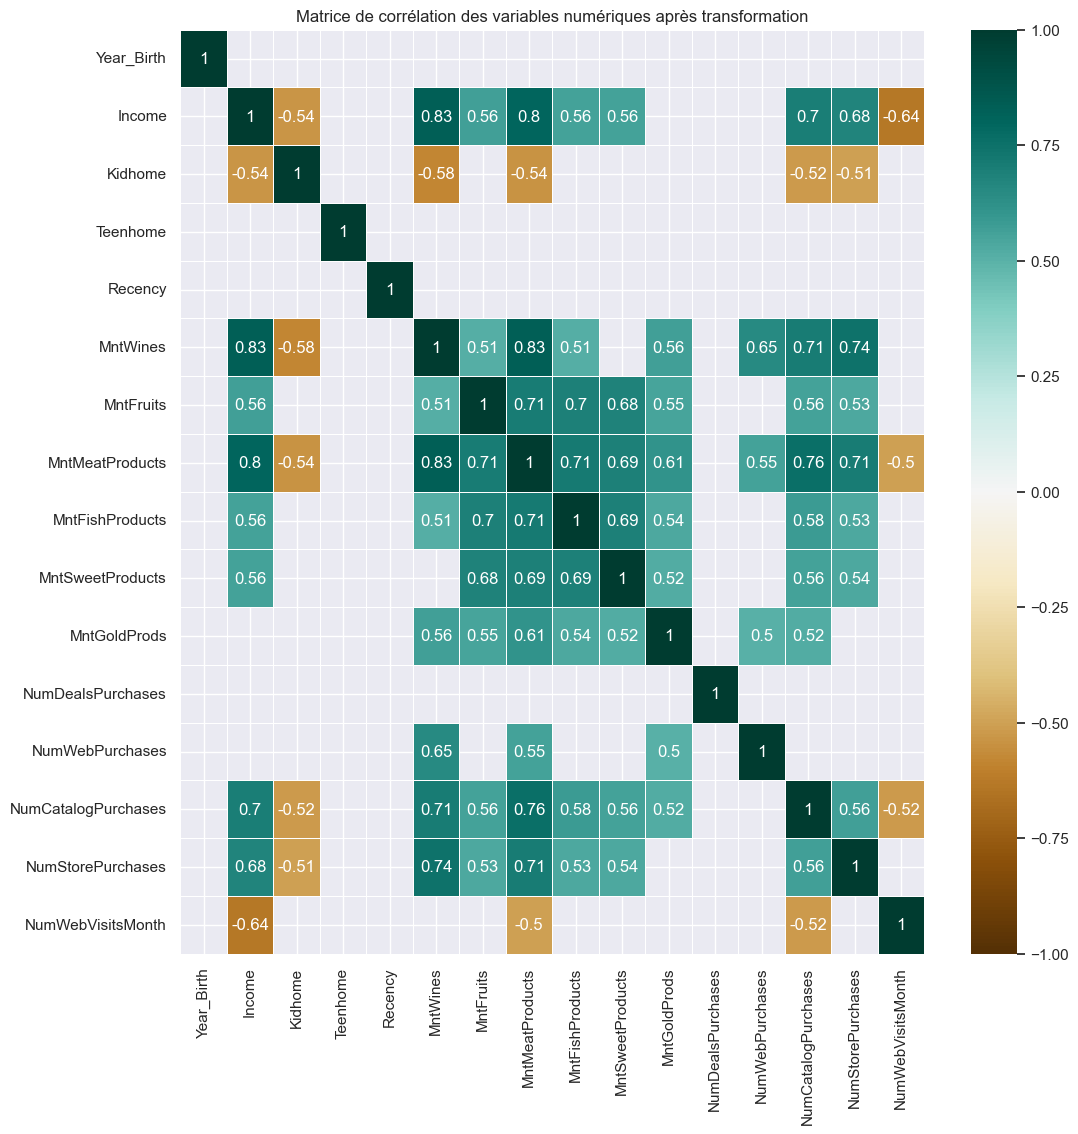

In [390]:
plt.figure(figsize=(12, 12))
plt.title("Matrice de corrélation des variables numériques après transformation")
sns.heatmap(
    df_transforme[var_numeriques].corr()[
        df_transforme[var_numeriques].corr().abs() > 0.5
    ],
    annot=True,
    cmap="BrBG",
    linewidths=0.5,
    vmax=1,
    vmin=-1,
)

## Variables catégoriques

### Encodage

In [391]:
# todo: One Hot Encoding, Target Encoding, etc

# Analyse multi-variée

## Clustering

In [392]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df_apres_scale = pd.DataFrame(
    scaler.fit_transform(df_transforme[var_numeriques]),
    columns=df[var_numeriques].columns,
)

In [393]:
from sklearn.cluster import KMeans

In [394]:
k3 = KMeans(n_clusters=3)
k4 = KMeans(n_clusters=4)

In [395]:
k3.fit(df_apres_scale[var_numeriques])
k4.fit(df_apres_scale[var_numeriques])

c:\Users\jules\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jules\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [396]:
df["cluster"] = k3.labels_

In [397]:
sns.histplot(df["cluster"])

<Axes: xlabel='cluster', ylabel='Count'>

<Axes: xlabel='Income', ylabel='Count'>

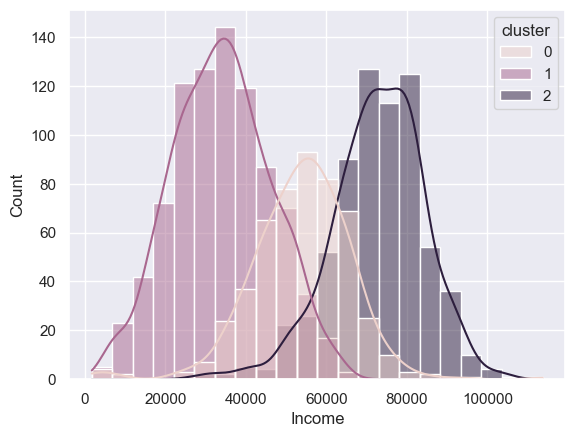

In [398]:
sns.histplot(df, x="Income", hue="cluster", kde=True)

<Axes: xlabel='Year_Birth', ylabel='Income'>

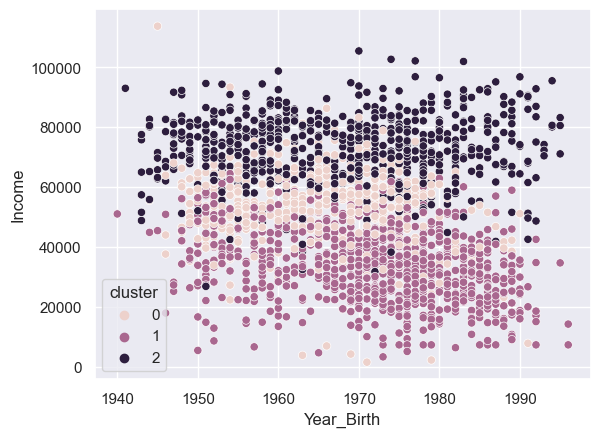

In [399]:
sns.scatterplot(df, x="Year_Birth", y="Income", hue="cluster")

In [400]:
df[var_numeriques + ["cluster"]]

Year_Birth   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
ID                                                                            
5524         1957  58138.0        0         0       58       635         88   
2174         1954  46344.0        1         1       38        11          1   
4141         1965  71613.0        0         0       26       426         49   
6182         1984  26646.0        1         0       26        11          4   
5324         1981  58293.0        1         0       94       173         43   
...           ...      ...      ...       ...      ...       ...        ...   
8080         1986  26816.0        0         0       50         5          1   
10870        1967  61223.0        0         1       46       709         43   
7270         1981  56981.0        0         0       91       908         48   
8235         1956  69245.0        0         1        8       428         30   
9405         1954  52869.0        1         1       40        84          3   

       MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
ID                                                                        
5524               546              172                88            88   
2174                 6                2                 1             6   
4141               127              111                21            42   
6182                20               10                 3             5   
5324               118               46                27            15   
...                ...              ...               ...           ...   
8080                 6                3                 4             3   
10870              182               42               118           247   
7270               217               32                12            24   
8235               214               80                30            61   
9405                61                2                 1            21   

       NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
ID                                                               
5524                   3                8                   10   
2174                   2                1                    1   
4141                   1                8                    2   
6182                   2                2                    0   
5324                   5                5                    3   
...                  ...              ...                  ...   
8080                   1                0                    0   
10870                  2                9                    3   
7270                   1                2                    3   
8235                   2                6                    5   
9405                   3                3                    1   

       NumStorePurchases  NumWebVisitsMonth  cluster  
ID                                                    
5524                   4                  7        2  
2174                   2                  5        1  
4141                  10                  4        2  
6182                   4                  6        1  
5324                   6                  5        0  
...                  ...                ...      ...  
8080                   3                  4        1  
10870                  4                  5        2  
7270                  13                  6        2  
8235                  10                  3        2  
9405                   4                  7        1  

[2045 rows x 17 columns]

<Axes: xlabel='cluster', ylabel='Count'>

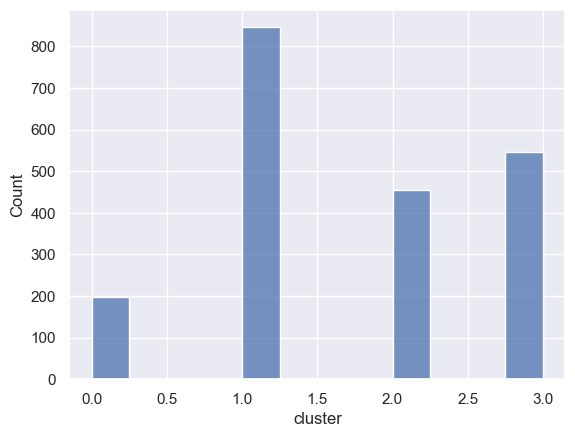

In [401]:
df["cluster"] = k4.labels_
sns.histplot(df["cluster"])

<Axes: xlabel='Income', ylabel='Count'>

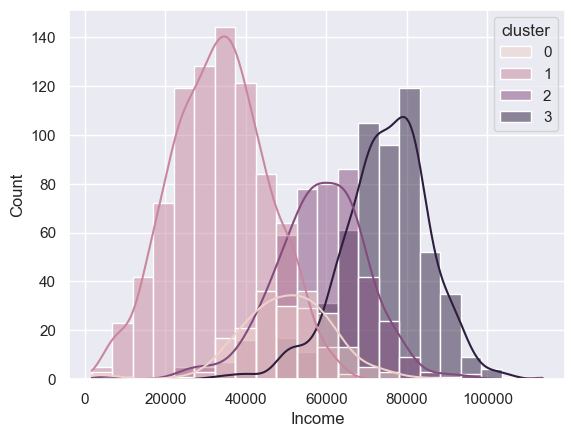

In [402]:
sns.histplot(df, x="Income", hue="cluster", kde=True)

<Axes: xlabel='Year_Birth', ylabel='Income'>

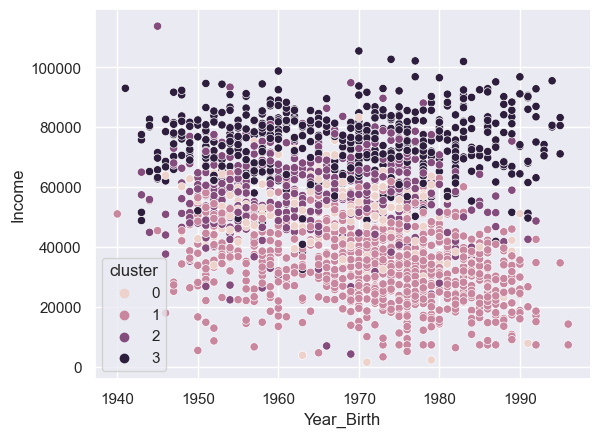

In [403]:
sns.scatterplot(df, x="Year_Birth", y="Income", hue="cluster")

## Analyse en Composantes Principales (ACP)

In [404]:
from sklearn.decomposition import PCA

In [405]:
# todo: centrer / réduire

In [406]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [407]:
scaler = StandardScaler()

In [408]:
df_apres_scale = pd.DataFrame(
    scaler.fit_transform(df[var_numeriques]), columns=df[var_numeriques].columns
)

In [409]:
df_apres_scale

Year_Birth    Income   Kidhome  Teenhome   Recency  MntWines  MntFruits  \
0      -1.018191  0.313644 -0.830211 -0.933952  0.311822  0.979058   1.550854   
1      -1.275221 -0.259126  1.029352  0.895485 -0.378790 -0.872702  -0.635761   
2      -0.332777  0.968050 -0.830211 -0.933952 -0.793157  0.358837   0.570647   
3       1.295080 -1.215749  1.029352 -0.933952 -0.793157 -0.872702  -0.560360   
4       1.038050  0.321171  1.029352 -0.933952  1.554923 -0.391956   0.419846   
...          ...       ...       ...       ...       ...       ...        ...   
2040    1.466433 -1.207493 -0.830211 -0.933952  0.035577 -0.890507  -0.635761   
2041   -0.161424  0.463465 -0.830211  0.895485 -0.102545  1.198658   0.419846   
2042    1.038050  0.257455 -0.830211 -0.933952  1.451331  1.789203   0.545514   
2043   -1.103868  0.853049 -0.830211  0.895485 -1.414707  0.364772   0.093111   
2044   -1.275221  0.057758  1.029352  0.895485 -0.309728 -0.656070  -0.585494   

      MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
0            1.715278         2.470350          1.452485      0.849021   
1           -0.722091        -0.648357         -0.629674     -0.729107   
2           -0.175940         1.351284         -0.151017     -0.036270   
3           -0.658900        -0.501595         -0.581809     -0.748352   
4           -0.216562         0.158837         -0.007420     -0.555897   
...               ...              ...               ...           ...   
2040        -0.722091        -0.630012         -0.557876     -0.786843   
2041         0.072311         0.085456          2.170472      3.909050   
2042         0.230289        -0.097997         -0.366413     -0.382688   
2043         0.216748         0.782579          0.064379      0.329394   
2044        -0.473840        -0.648357         -0.629674     -0.440425   

      NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
0              0.352265         1.391717             2.639140   
1             -0.173561        -1.113619            -0.583829   
2             -0.699388         1.391717            -0.225722   
3             -0.173561        -0.755714            -0.941937   
4              1.403918         0.318002             0.132386   
...                 ...              ...                  ...   
2040          -0.699388        -1.471524            -0.941937   
2041          -0.173561         1.749622             0.132386   
2042          -0.699388        -0.755714             0.132386   
2043          -0.173561         0.675907             0.848601   
2044           0.352265        -0.397808            -0.583829   

      NumStorePurchases  NumWebVisitsMonth  
0             -0.554283           0.685454  
1             -1.173180          -0.139107  
2              1.302407          -0.551387  
3             -0.554283           0.273173  
4              0.064613          -0.139107  
...                 ...                ...  
2040          -0.863732          -0.551387  
2041          -0.554283          -0.139107  
2042           2.230753           0.273173  
2043           1.302407          -0.963667  
2044          -0.554283           0.685454  

[2045 rows x 16 columns]

In [410]:
# for var in var_numeriques:
#     _, ax = plt.subplots(1, 2, figsize=(8, 2))
#     sns.boxplot(df_apres_scale[var], width=0.25, ax=ax[0])
#     sns.histplot(df_apres_scale[var], kde=True, ax=ax[1])
#     plt.show()

In [411]:
acp = PCA(random_state=0)

In [412]:
acp.fit(df_apres_scale)

PCA(random_state=0)

In [413]:
variance_expliquee = pd.Series(
    acp.explained_variance_ratio_, index=df[var_numeriques].columns
)

In [414]:
variance_expliquee

Year_Birth             0.396523
Income                 0.122371
Kidhome                0.078477
Teenhome               0.062785
Recency                0.050996
MntWines               0.045261
MntFruits              0.038370
MntMeatProducts        0.036575
MntFishProducts        0.029248
MntSweetProducts       0.027067
MntGoldProds           0.026548
NumDealsPurchases      0.024251
NumWebPurchases        0.021775
NumCatalogPurchases    0.016894
NumStorePurchases      0.014009
NumWebVisitsMonth      0.008851
dtype: float64

<Axes: >

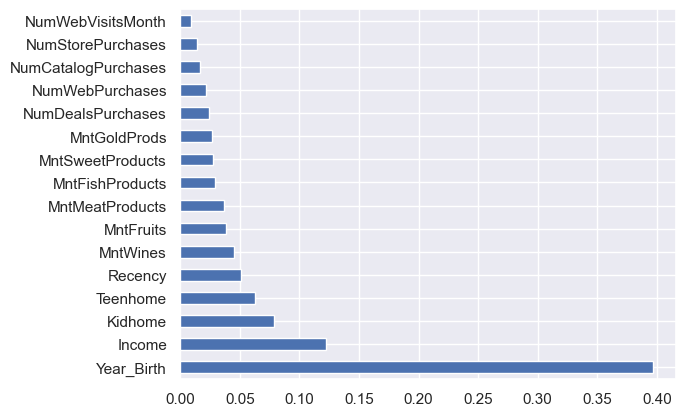

In [415]:
variance_expliquee.plot.barh()

In [416]:
df_acp = pd.DataFrame(acp.fit_transform(df_apres_scale), index=df.index)

In [417]:
df_acp.head()

0         1         2         3         4         5         6   \
ID                                                                           
5524  3.847902 -0.074295  1.297720  0.439261  1.078878  0.380220  2.503497   
2174 -2.258521  0.266545 -1.555343 -0.296569  0.921423 -0.561184  0.306077   
4141  1.973928 -0.231867 -0.156503 -0.992775 -0.303893  0.520124  0.194640   
6182 -2.563885 -1.421275  0.765474 -0.744829 -0.326998 -0.279775 -0.275984   
5324 -0.253323 -0.273556  1.511262  1.657309 -0.208252 -1.204047 -0.093077   

            7         8         9         10        11        12        13  \
ID                                                                           
5524  0.143059 -0.362198  0.907968  1.216594  0.493444  0.449480 -0.721678   
2174  0.550722  0.534242 -0.345348  0.227844  0.082304 -0.082152 -0.120445   
4141 -1.048813 -0.351264 -0.545750 -1.297542  0.953551  0.616611 -0.158256   
6182 -0.062809 -0.014277 -0.002119 -0.392115  0.022203  0.096591 -0.061492   
5324 -0.131715 -0.042901 -0.201168 -0.505891 -0.160253  0.815473 -0.523780   

            14        15  
ID                        
5524  0.376095  0.084389  
2174 -0.055367 -0.114679  
4141 -0.249226 -0.329684  
6182 -0.007816  0.281474  
5324 -0.349255 -0.529759

<Axes: xlabel='0', ylabel='1'>

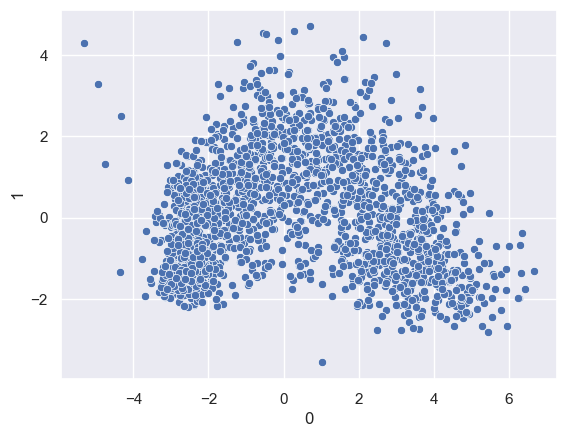

In [418]:
sns.scatterplot(df_acp, x=0, y=1)

### Cercle de corrélations

In [419]:
from mlxtend.plotting import plot_pca_correlation_graph

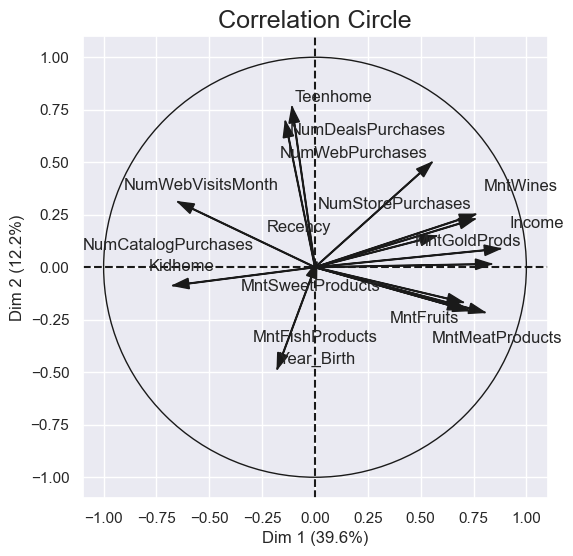

In [420]:
_, correlation_matrix = plot_pca_correlation_graph(
    df_apres_scale,
    df_apres_scale.columns,
    X_pca=df_acp.iloc[:, :2],
    explained_variance=acp.explained_variance_[:2],
    dimensions=(1, 2),
)

<Axes: >

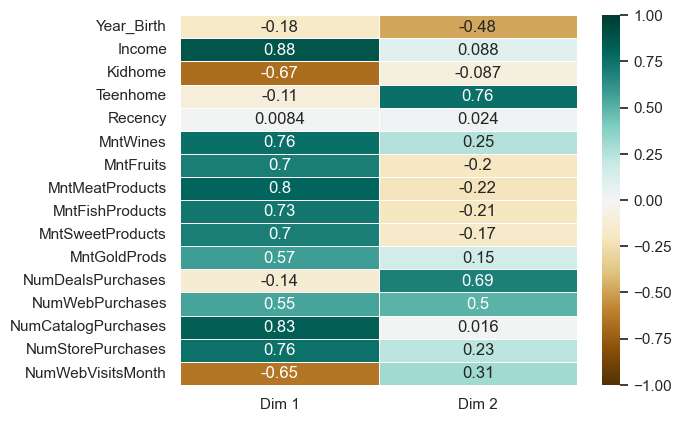

In [421]:
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="BrBG",
    linewidths=0.5,
    vmax=1,
    vmin=-1,
)

### Test clusters

In [422]:
df_acp["clusterk3"] = k3.labels_
df_acp["clusterk4"] = k4.labels_

<Axes: xlabel='0', ylabel='1'>

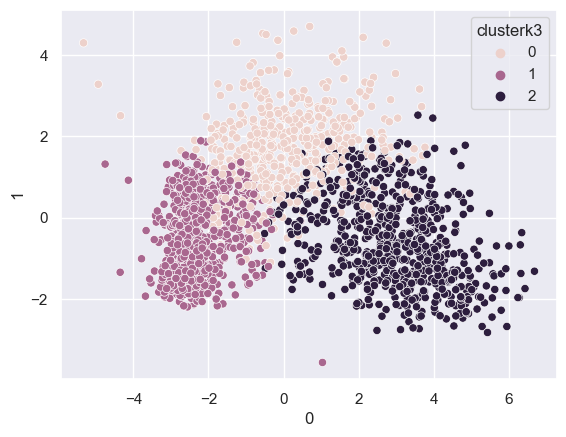

In [423]:
sns.scatterplot(df_acp, x=0, y=1, hue="clusterk3")

In [424]:
df_acp.head()

0         1         2         3         4         5         6  \
ID                                                                           
5524  3.847902 -0.074295  1.297720  0.439261  1.078878  0.380220  2.503497   
2174 -2.258521  0.266545 -1.555343 -0.296569  0.921423 -0.561184  0.306077   
4141  1.973928 -0.231867 -0.156503 -0.992775 -0.303893  0.520124  0.194640   
6182 -2.563885 -1.421275  0.765474 -0.744829 -0.326998 -0.279775 -0.275984   
5324 -0.253323 -0.273556  1.511262  1.657309 -0.208252 -1.204047 -0.093077   

             7         8         9        10        11        12        13  \
ID                                                                           
5524  0.143059 -0.362198  0.907968  1.216594  0.493444  0.449480 -0.721678   
2174  0.550722  0.534242 -0.345348  0.227844  0.082304 -0.082152 -0.120445   
4141 -1.048813 -0.351264 -0.545750 -1.297542  0.953551  0.616611 -0.158256   
6182 -0.062809 -0.014277 -0.002119 -0.392115  0.022203  0.096591 -0.061492   
5324 -0.131715 -0.042901 -0.201168 -0.505891 -0.160253  0.815473 -0.523780   

            14        15  clusterk3  clusterk4  
ID                                              
5524  0.376095  0.084389          2          3  
2174 -0.055367 -0.114679          1          1  
4141 -0.249226 -0.329684          2          3  
6182 -0.007816  0.281474          1          1  
5324 -0.349255 -0.529759          0          0

In [425]:
sns.scatterplot(df_acp, x=0, y=1, hue=df["Response"])

<Axes: xlabel='0', ylabel='1'>

In [426]:
sns.scatterplot(df_acp, x=0, y=2, hue=df["Response"])

<Axes: xlabel='0', ylabel='2'>

<Axes: xlabel='0', ylabel='1'>

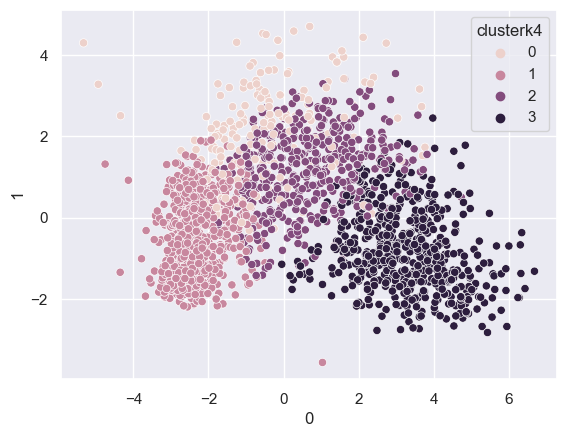

In [427]:
sns.scatterplot(df_acp, x=0, y=1, hue="clusterk4")

## Analyse Factorielle des Correspondances (AFC)

In [428]:
# todo

## Analyse des Correspondances Multiples (ACM)

In [429]:
# todo

# Régressions

## Régression PLS

In [430]:
# todo: refaire la régression PLS mais PAS sur une variable catégorique (erreur ici)

In [431]:
from sklearn.cross_decomposition import PLSRegression

In [432]:
# Initialisation de l'objet PLSRegression avec 2 composantes PLS
pls = PLSRegression(n_components=2)

In [433]:
# Apprentissage du modèle sur les données
pls.fit(df_transforme[var_numeriques], df_transforme["Response"])

PLSRegression()

In [434]:
# Prédiction de la variable cible sur de nouvelles données
y_pred = pls.predict(df_transforme[var_numeriques])

In [435]:
# Evaluation de la performance du modèle
r2 = pls.score(df_transforme[var_numeriques], df_transforme["Response"].astype(int))

In [436]:
r2

0.16035127204927357

## Régression linéaire simple

Modèle simple : une variable à expliquer Y et une seule variable explicative X.  

$$y_i = \beta_0 + \beta_1 X_i + \epsilon_i$$

Hypothèses à vérifier pour la régression linéaire simple :  

1) il existe une corrélation linéaire entre X et Y

1) la distribution de l’erreur ε est indépendante de la variable X (exogénéité)

2) l'erreur suit une loi normale centrée i.e. E(ε_i) = 0

3) l’erreur est de variance constante (homoscédasticité)
i.e Var(ε_i) = s, une constante

4) les erreurs sont indépendantes (absence d'autocorrélation)
i.e. Cov(εi, εj) = 0, pour tout i, j

In [602]:
X = np.array(df_transforme["Income"])
Y = np.array(df_transforme["NumStorePurchases"])

### Hypothèse 1 : corrélation linéaire

In [603]:
from scipy.stats import pearsonr

In [604]:
print(
    "Le coefficient de corrélation linéaire entre X et Y vaut",
    pearsonr(X, Y)[0],
    "la pvalue associée vaut",
    pearsonr(X, Y)[1],
    "il existe donc bien une relation linéaire entre X et Y.",
)

Le coefficient de corrélation linéaire entre X et Y vaut 0.6790710752806038 la pvalue associée vaut 1.3161539637591645e-276 il existe donc bien une relation linéaire entre X et Y.


Le reste des hypothèses à tester requiert d'effectuer la régression linéaire :

In [605]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [606]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [607]:
model = LinearRegression().fit(X_train.reshape(-1, 1), Y_train)
Y_train_hat = model.predict(X_train.reshape(-1, 1))

Text(0.5, 1.0, "Régression linéaire du nombre d'achats en magasin en fonction du revenu")

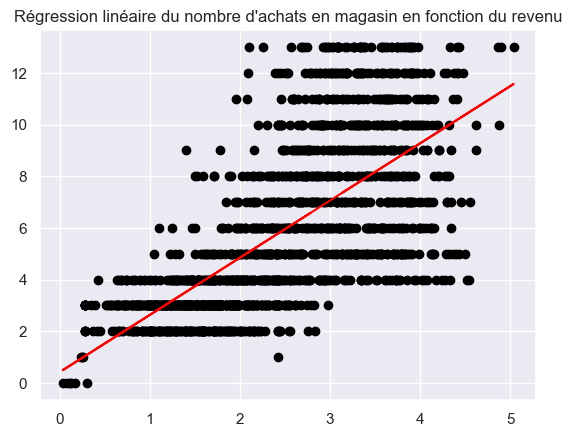

In [608]:
plt.scatter(X_train, Y_train, color="black")
plt.plot(X_train, Y_train_hat, color="red")
plt.title("Régression linéaire du nombre d'achats en magasin en fonction du revenu")

In [517]:
print(model.intercept_, model.coef_, model.score(X_train.reshape(-1, 1), Y_train))

0.41932027328891675 [2.21369643] 0.47029950823152755


Equation de régression :

$$y_i = 0.46 + 2.21 * x_i$$

### Hypothèse 2 : exogénéité

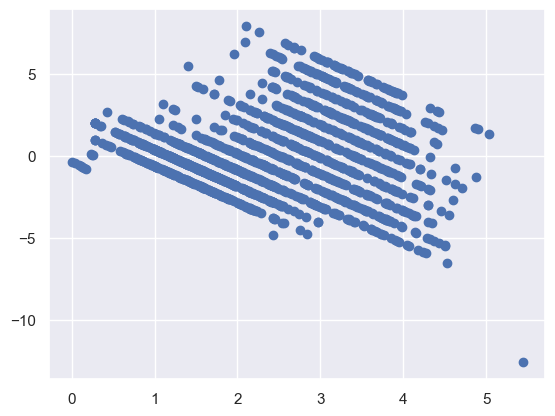

In [445]:
residuals = Y_train - Y_train_hat

plt.scatter(X_train, residuals)

In [446]:
print(
    "Le coefficient de corrélation entre X et les residus vaut",
    pearsonr(X_train, residuals)[0],
    ". On a bien indépendance et donc exogénéité.",
)

Le coefficient de corrélation entre X et les residus vaut 7.261172999678545e-16 . On a bien indépendance et donc exogénéité.


### Hypothèse 3 : l'erreur suit une loi normale centrée i.e. E(ε_i) = 0

In [447]:
import statistics
from scipy import stats

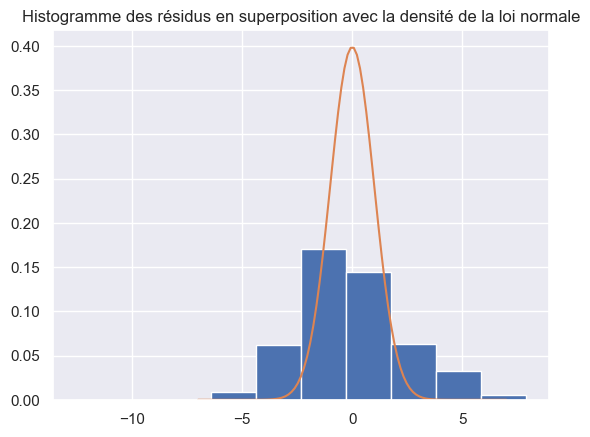

In [448]:
plt.hist(residuals, density=True)

x = np.linspace(-7, 7, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1))
plt.title("Histogramme des résidus en superposition avec la densité de la loi normale")
plt.show()

In [449]:
print("La moyenne des résidus vaut", statistics.mean(residuals))
print("Mais les résidus ne suivent pas une loi normale")

La moyenne des résidus vaut -2.4708569881786035e-16
Mais les résidus ne suivent pas une loi normale


On constate sur le qqplot que les points ne suivent pas la droite x = y


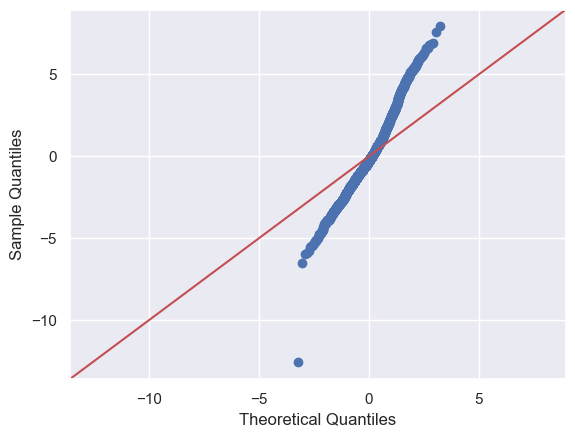

In [450]:
sm.qqplot(residuals, line="45")
print("On constate sur le qqplot que les points ne suivent pas la droite x = y")

In [451]:
print(
    "Un test de shapiro, pour tester l'hypothèse de normalité, nous donne une pvalue de",
    stats.shapiro(residuals)[1],
    ". On rejette l'hypothèse nulle et on conclut que les résidus ne suivent pas une loi normale.",
)

Un test de shapiro, pour tester l'hypothèse de normalité, nous donne une pvalue de 7.587964002790659e-13 . On rejette l'hypothèse nulle et on conclut que les résidus ne suivent pas une loi normale.


### Hypothèse 4 : homoscédasticité

In [620]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, "-", color = "red")

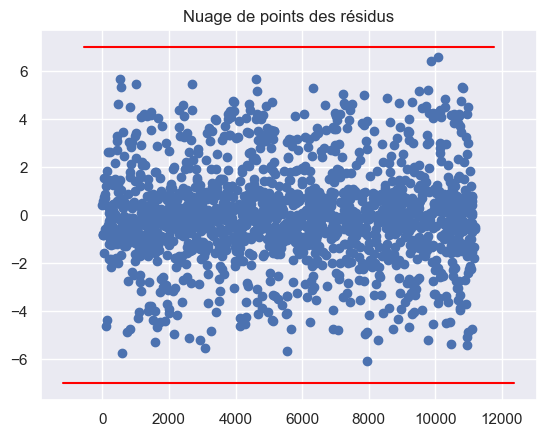

In [677]:
plt.plot(residuals, "bo")
plt.title("Nuage de points des résidus")
abline(0, 7)
abline(0, -7)

In [454]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

In [510]:
fit = sm.OLS(Y_train, sm.add_constant(X_train)).fit()

In [512]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     1451.
Date:                Fri, 24 Mar 2023   Prob (F-statistic):          9.81e-228
Time:                        15:31:34   Log-Likelihood:                -3726.4
No. Observations:                1636   AIC:                             7457.
Df Residuals:                    1634   BIC:                             7468.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4193      0.153      2.738      0.006       0.119       0.720
x1             2.2137      0.058     38.089      0.000       2.100       2.328
==============================================================================
Omnibus:                       51.217   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.343
Skew:                           0.447   Prob(JB):                     9.60e-13
Kurtosis:                       3.105   Cond. No.                         7.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [678]:
gq_names = ["F statistic", "p-value"]
gq_test = sms.het_goldfeldquandt(fit.resid, fit.model.exog)
lzip(gq_names, gq_test)

[('F statistic', 1.005758558851296), ('p-value', 0.46775077410560034)]

In [674]:
bp_test = sms.het_breuschpagan(fit.resid, fit.model.exog)
bp_names = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
print(lzip(bp_names, bp_test))

[('Lagrange multiplier statistic', 482.31195358712836), ('p-value', 7.791104304617164e-87), ('f-value', 30.65147083402164), ('f p-value', 7.985346593580764e-106)]
Il y a bien homoscédasticité.


### Hypothèse 5 : absence d'autocorrélation

In [458]:
from statsmodels.graphics.regressionplots import *

On remarque une absence d'autocorrélation.


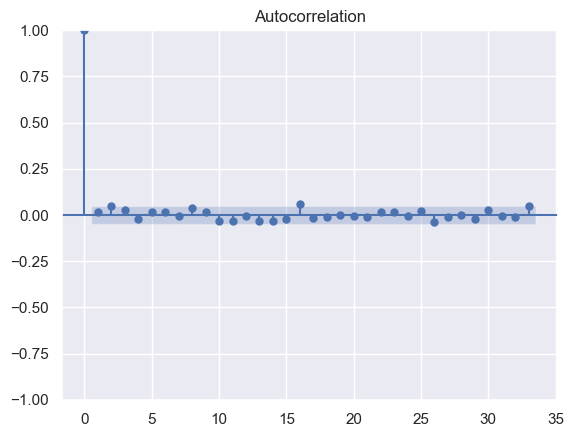

In [518]:
sm.graphics.tsa.plot_acf(residuals)
print("On remarque une absence d'autocorrélation.")

### Distance de Cook

In [519]:
influence = fit.get_influence()
cooks = influence.cooks_distance

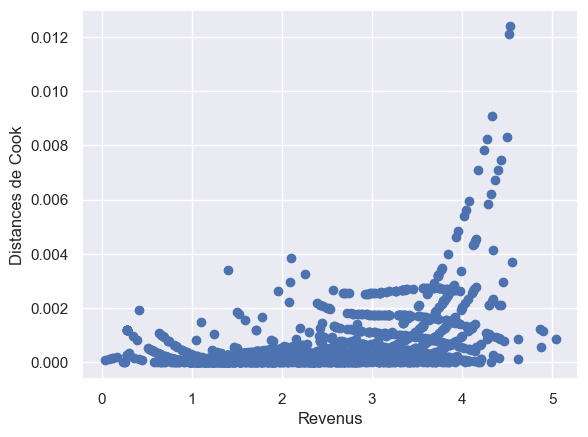

In [520]:
plt.scatter(X_train, cooks[0])
plt.xlabel("Revenus")
plt.ylabel("Distances de Cook")
plt.show()

In [521]:
cooks_indexes = [i for i, x in enumerate(cooks[0] > 0.005) if x]
print(cooks_indexes)
# affiche les indexes des individus dont les distances de cook dépassent une certaine valeur

[219, 532, 633, 746, 845, 992, 1026, 1100, 1117, 1166, 1345, 1438, 1504, 1603, 1609]


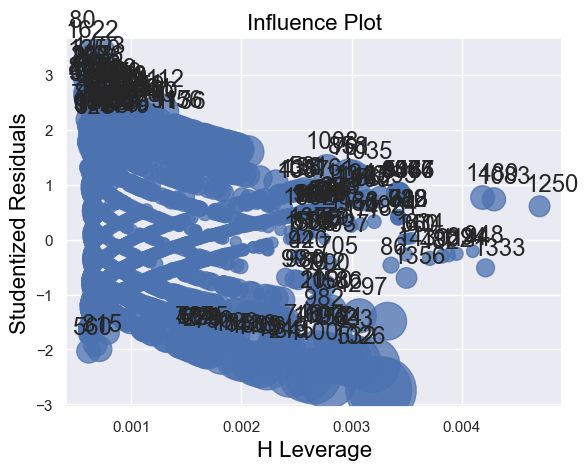

In [522]:
influence_plot(fit)
print("")

### Score du modèle

#### Qualité d'ajustement

In [464]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [465]:
print(f"Le R² du modèle vaut {model.score(X_train.reshape(-1, 1), Y_train)}")

Le R² du modèle vaut 0.4761000100600148


In [466]:
print(f"MSE = {mean_squared_error(Y_train, Y_train_hat)}")
print(f"RMSE = {mean_squared_error(Y_train, Y_train_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_train, Y_train_hat)}")

MSE = 5.516923925483293
RMSE = 2.3488133015383093
MAE = 1.8283053128589473


#### Qualité de prédiction

Train / test split

In [467]:
print(
    f"R² du modèle sur les données d'entraînement = {model.score(X_train.reshape(-1, 1), Y_train)}"
)
print(
    f"R² du modèle sur les données de test = {model.score(X_test.reshape(-1, 1), Y_test)}"
)

R² du modèle sur les données d'entraînement = 0.4761000100600148
R² du modèle sur les données de test = 0.39614985525783386


In [523]:
Y_test_hat = model.predict(X_test.reshape(-1, 1))

Text(0.5, 1.0, "Nombre d'achats en magasin en fonction du revenu : données test")

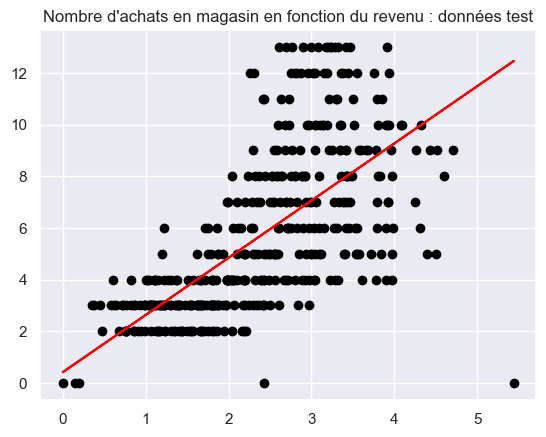

In [524]:
plt.scatter(X_test, Y_test, color="black")
plt.plot(X_test, Y_test_hat, color="red")
plt.title("Nombre d'achats en magasin en fonction du revenu : données test")

In [525]:
print(f"MSE = {mean_squared_error(Y_test, Y_test_hat)}")
print(f"RMSE = {mean_squared_error(Y_test, Y_test_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_test, Y_test_hat)}")

MSE = 5.8538725719997435
RMSE = 2.4194777477794136
MAE = 1.8268826341039772


In [471]:
# todo: cross-validation

## Régression linéaire multiple

Modèle multiple : une variable à expliquer Y et N variables explicatives X_i  

$$y_i = \beta_0 + \beta_1 X_i(1) + \beta_2 X_i(2) + \beta_3 X_i(3) + ... + \beta_P X_i(P) + \epsilon_i$$

Hypothèses à vérifier pour la régression linéaire multiple :  

1) il existe une corrélation linéaire entre X_i et Y

2) Cov(X_p_i, ε_j) = 0, pour tout i, j (exogénéité) et pour chaque variable explicative X_p

3) l'erreur suit une loi normale centrée i.e. E(ε_i) = 0

4) l’erreur est de variance constante (homoscédasticité)
i.e Var(εi) = s, une constante

5) les erreurs sont indépendantes (absence d'autocorrélation)
i.e. Cov(εi, εj) = 0, pour tout i, j  

6) absence de colinéarité entre les variables explicatives,  
i.e. X_t * X est régulière, det(X_t * X) ≠ 0 

Pour les besoins de la régression linéaire, nous créons des variables muettes (dummy variables) pour inclure les variables catégoriques `Education` et `Marital_status` à la régression.

In [472]:
df_reg = df_transforme.copy()

In [473]:
df_reg = pd.get_dummies(df_reg, columns=["Education", "Marital_Status"])

In [474]:
df_reg.columns

Index(['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
       'NbAcceptedCampaigns', 'HasAcceptedCampaigns', 'NbChildren',
       'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Marital_Status_Absurd',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Marital_Status_YOLO'],
      dtype='object')

Pour cette régression, on suppose que l'entreprise veut profiler au mieux les clients qui achètent dans le magasin. C'est pourquoi la variable d'intérêt pour la régression sera le `nombre d'achats en magasin`.  

Nos variables explicatives sont des variables numériques et des variables catégoriques transformées en variables muettes.
Nous commençons par un grand nombre de variables explicatives puis nous en éliminerons progressivement pendant la vérifications des hypothèses.

In [636]:
var_numeriques_reg = [
        "Income",
        "Year_Birth",
        "Recency",
        "NbAcceptedCampaigns",

        "NumWebPurchases",
        "NumDealsPurchases",
        "NumWebVisitsMonth",
        "NumCatalogPurchases",

        "MntWines",
        "MntFruits",
        "MntMeatProducts",
        "MntFishProducts",
        "MntSweetProducts",
        "MntGoldProds"
        ]

var_categoriques_reg = [
        "NbChildren",

        'Education_2n Cycle',
        'Education_Basic',
        'Education_Graduation',
        'Education_Master',
        'Education_PhD',

        'Marital_Status_Divorced',
        'Marital_Status_Married',
        'Marital_Status_Single',
        'Marital_Status_Together',
        'Marital_Status_Widow'
]

In [637]:
X = df_reg[var_categoriques_reg + var_numeriques_reg]
Y = df_reg["NumStorePurchases"]

In [638]:
print("Nous avons", X.shape[1], "variables explicatives au début de la régression dont",
    X[var_numeriques_reg].shape[1], "variables numériques.")

Nous avons 25 variables explicatives au début de la régression dont 14 variables numériques.


### Hypothèse 1 : lien linéaire entre Y et les variables explicatives numériques

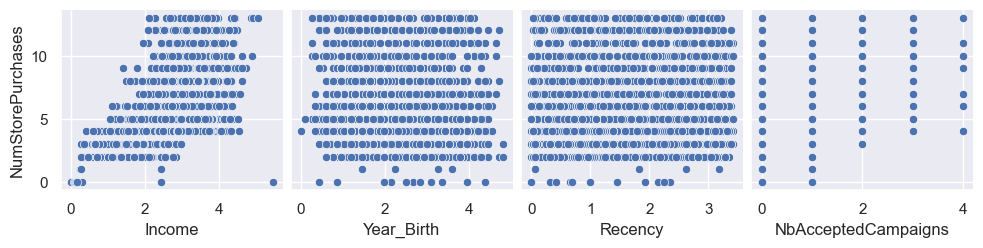

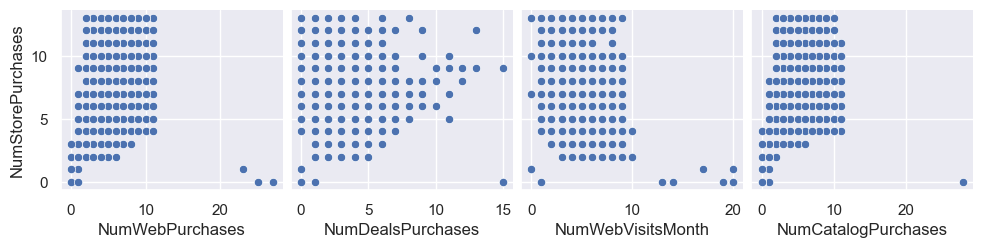

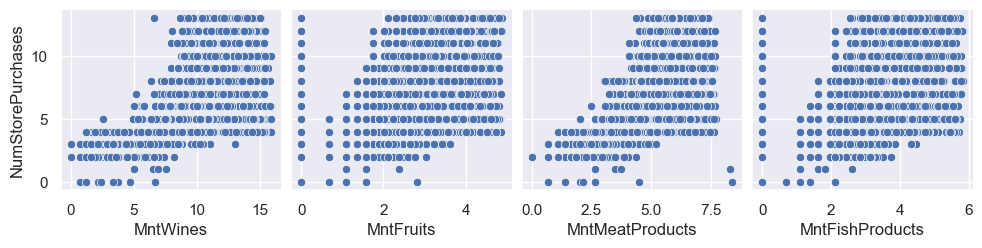

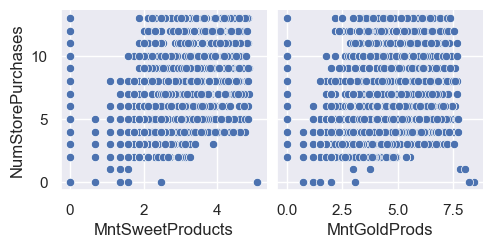

In [586]:
sns.pairplot(df_transforme, x_vars=var_numeriques_reg[0:4], y_vars="NumStorePurchases")
sns.pairplot(df_transforme, x_vars=var_numeriques_reg[4:8], y_vars="NumStorePurchases")
sns.pairplot(df_transforme, x_vars=var_numeriques_reg[8:12], y_vars="NumStorePurchases")
sns.pairplot(df_transforme, x_vars=var_numeriques_reg[12:], y_vars="NumStorePurchases")

In [639]:
for x in X[var_numeriques_reg].columns:
    corr = pearsonr(X[x], Y)
    print("Le coefficient de corrélation linéaire entre Y et", x, "vaut", corr[0], "la pvalue vaut", corr[1])

Le coefficient de corrélation linéaire entre Y et Income vaut 0.6790710752806038 la pvalue vaut 1.3161539637591645e-276
Le coefficient de corrélation linéaire entre Y et Year_Birth vaut -0.1452612037262372 la pvalue vaut 4.112323845048852e-11
Le coefficient de corrélation linéaire entre Y et Recency vaut 0.0014633262194708669 la pvalue vaut 0.9472714287541374
Le coefficient de corrélation linéaire entre Y et NbAcceptedCampaigns vaut 0.2123409758278407 la pvalue vaut 2.8026864212884285e-22
Le coefficient de corrélation linéaire entre Y et NumWebPurchases vaut 0.48685945140100195 la pvalue vaut 3.45783788946382e-122
Le coefficient de corrélation linéaire entre Y et NumDealsPurchases vaut 0.07208375232131882 la pvalue vaut 0.0011062951780020662
Le coefficient de corrélation linéaire entre Y et NumWebVisitsMonth vaut -0.4391931195077409 la pvalue vaut 3.4250524721831053e-97
Le coefficient de corrélation linéaire entre Y et NumCatalogPurchases vaut 0.5627033023451972 la pvalue vaut 3.924437

In [640]:
#TODO: faire un joli affichage avec SNS heatmap

On décide déjà d'écarter la variable `Recency` de la régression.

In [641]:
del X['Recency']
var_numeriques_reg.remove('Recency')

### Réalisation du modèle

In [645]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [646]:
model_multiple = LinearRegression().fit(X_train, Y_train)
Y_train_hat = model_multiple.predict(X_train)

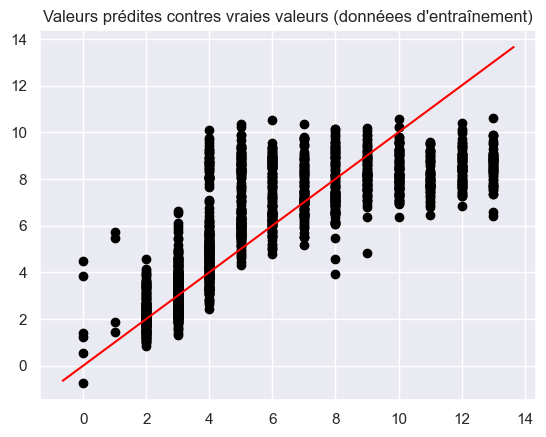

In [647]:
plt.scatter(Y_train, Y_train_hat, color="black")
plt.title("Valeurs prédites contres vraies valeurs (donnéees d'entraînement)")
abline(1, 0)

### Hypothèse 2 : exogénéité sur les variables numériques
(Cela n'a pas de sens de tester l'exogénéité sur les variables catégoriques car la notion de corrélation ne fonctionne pas avec celles-ci.)

In [653]:
residuals = Y_train - Y_train_hat

In [656]:
for x in X_train[var_numeriques_reg].columns:
    corr = pearsonr(X_train[x], residuals)
    print(
        "Le coefficient de corrélation entre", x, "et les residus vaut",
        corr[0], "et la pvalue associée vaut", corr[1]
    )

Le coefficient de corrélation entre Income et les residus vaut -1.058316845617413e-15 et la pvalue associée vaut 0.9999999999999651
Le coefficient de corrélation entre Year_Birth et les residus vaut 2.82651506366971e-16 et la pvalue associée vaut 0.9999999999999919
Le coefficient de corrélation entre NbAcceptedCampaigns et les residus vaut -3.629908873481469e-16 et la pvalue associée vaut 0.9999999999999883
Le coefficient de corrélation entre NumWebPurchases et les residus vaut -3.541275345880779e-16 et la pvalue associée vaut 0.9999999999999883
Le coefficient de corrélation entre NumDealsPurchases et les residus vaut 4.686192840025472e-16 et la pvalue associée vaut 0.9999999999999883
Le coefficient de corrélation entre NumWebVisitsMonth et les residus vaut 8.204970990827176e-16 et la pvalue associée vaut 0.9999999999999747
Le coefficient de corrélation entre NumCatalogPurchases et les residus vaut -8.701806636368659e-16 et la pvalue associée vaut 0.9999999999999747
Le coefficient de c

Il n'y a pas d'endogénéité.

### Hypothèse 3 : l'erreur suit une loi normale centrée i.e. E(ε_i) = 0

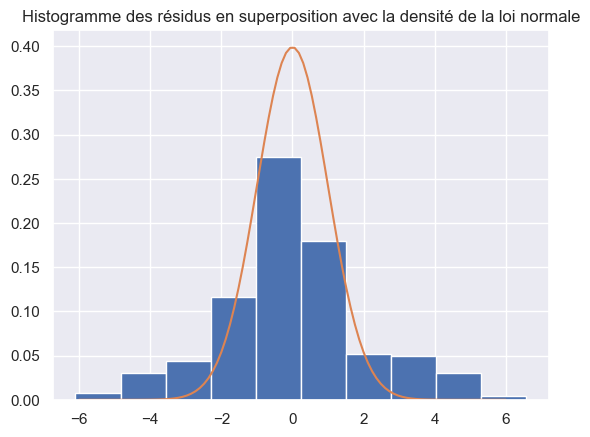

In [658]:
plt.hist(residuals, density=True)

x = np.linspace(-6, 6, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1))
plt.title("Histogramme des résidus en superposition avec la densité de la loi normale")
plt.show()

In [660]:
print("La moyenne des résidus vaut", statistics.mean(residuals))

La moyenne des résidus vaut -9.692056991257021e-16


On constate sur le qqplot que les points ne suivent pas la droite x = y


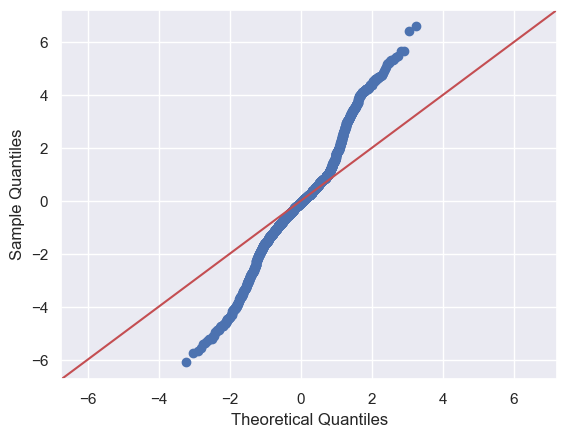

In [661]:
sm.qqplot(residuals, line="45")
print("On constate sur le qqplot que les points ne suivent pas la droite x = y")

In [663]:
print(
    "Un test de shapiro, pour tester l'hypothèse de normalité, nous donne une pvalue de",
    stats.shapiro(residuals)[1],
    ". On rejette l'hypothèse nulle et on conclut que les résidus ne suivent pas une loi normale.",
)

Un test de shapiro, pour tester l'hypothèse de normalité, nous donne une pvalue de 3.973341823017073e-16 . On rejette l'hypothèse nulle et on conclut que les résidus ne suivent pas une loi normale.


### Hypothèse 4 : homoscédasticité

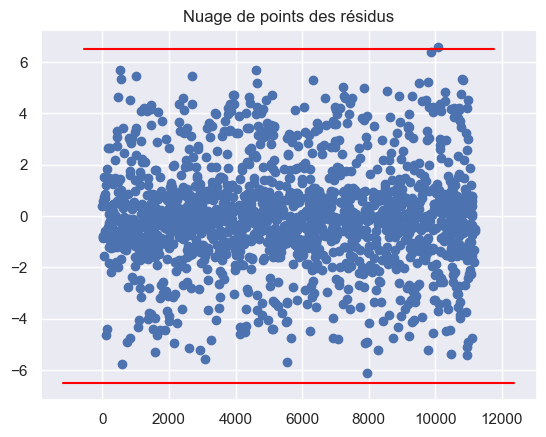

In [666]:
plt.plot(residuals, "bo")
plt.title("Nuage de points des résidus")
abline(0, 6.5)
abline(0, -6.5)

In [667]:
fit = sm.OLS(Y_train, sm.add_constant(X_train)).fit()

In [668]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      NumStorePurchases   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     120.9
Date:                Fri, 24 Mar 2023   Prob (F-statistic):          1.60e-321
Time:                        18:09:20   Log-Likelihood:                -3449.1
No. Observations:                1636   AIC:                             6944.
Df Residuals:                    1613   BIC:                             7068.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.1164      0.263      4.252      0.000       0.601       1.632
NbChildren                 -0.2059      0.099     -2.087      0.037      -0.399      -0.012
Education_2n Cycle          0.4084      0.166      2.455      0.014       0.082       0.735
Education_Basic             0.6801      0.288      2.361      0.018       0.115       1.245
Education_Graduation        0.0099      0.112      0.088      0.930      -0.211       0.230
Education_Master           -0.0326      0.139     -0.234      0.815      -0.306       0.240
Education_PhD               0.0506      0.136      0.372      0.710      -0.217       0.318
Marital_Status_Divorced     0.3121      0.150      2.076      0.038       0.017       0.607
Marital_Status_Married      0.3234      0.104      3.103      0.002       0.119       0.528
Marital_Status_Single       0.0786      0.121      0.650      0.516      -0.159       0.316
Marital_Status_Together     0.1935      0.113      1.713      0.087      -0.028       0.415
Marital_Status_Widow        0.2090      0.229      0.911      0.362      -0.241       0.659
Income                      0.2647      0.128      2.074      0.038       0.014       0.515
Year_Birth                  0.0576      0.055      1.043      0.297      -0.051       0.166
NbAcceptedCampaigns        -0.3867      0.084     -4.617      0.000      -0.551      -0.222
NumWebPurchases             0.0437      0.028      1.561      0.119      -0.011       0.099
NumDealsPurchases           0.1072      0.037      2.927      0.003       0.035       0.179
NumWebVisitsMonth          -0.1821      0.032     -5.618      0.000      -0.246      -0.119
NumCatalogPurchases        -0.1065      0.029     -3.639      0.000      -0.164      -0.049
MntWines                    0.4101      0.033     12.471      0.000       0.346       0.475
MntFruits                   0.1047      0.055      1.887      0.059      -0.004       0.214
MntMeatProducts             0.1076      0.077      1.407      0.160      -0.042       0.258
MntFishProducts             0.1247      0.048      2.584      0.010       0.030       0.219
MntSweetProducts            0.2224      0.054      4.147      0.000       0.117       0.328
MntGoldProds               -0.0399      0.039     -1.034      0.302      -0.116       0.036
==============================================================================
Omnibus:                       23.189   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.807
Skew:                           0.156   Prob(JB):                     7.52e-08
Kurtosis:                       3.620   Cond. No.                     3.28e+16
==============================================================================

Notes:
[1] Standard Errors assum

In [669]:
bp_test = sms.het_breuschpagan(fit.resid, fit.model.exog)

In [670]:
bp_names = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
print(lzip(bp_names, bp_test))
print("Il y a bien homoscédasticité.")

[('Lagrange multiplier statistic', 482.31195358712836), ('p-value', 7.791104304617164e-87), ('f-value', 30.65147083402164), ('f p-value', 7.985346593580764e-106)]
Il y a bien homoscédasticité.


In [476]:
model_multiple_sm = sm.OLS(Y, X).fit()

In [477]:
model_multiple_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      NumStorePurchases   R-squared (uncentered):                   0.909
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              1345.
Date:                Fri, 24 Mar 2023   Prob (F-statistic):                        0.00
Time:                        14:56:46   Log-Likelihood:                         -4324.4
No. Observations:                2045   AIC:                                      8679.
Df Residuals:                    2030   BIC:                                      8763.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Income                  0.3769      0.100      3.763      0.000       0.181       0.573
NumWebPurchases        -0.0111      0.023     -0.493      0.622      -0.055       0.033
NumDealsPurchases       0.1225      0.032      3.819      0.000       0.060       0.185
NumWebVisitsMonth      -0.0951      0.022     -4.346      0.000      -0.138      -0.052
NumCatalogPurchases    -0.1094      0.027     -4.067      0.000      -0.162      -0.057
MntWines                0.4345      0.028     15.759      0.000       0.380       0.489
MntFruits               0.1520      0.050      3.069      0.002       0.055       0.249
MntMeatProducts         0.1342      0.066      2.032      0.042       0.005       0.264
MntFishProducts         0.1070      0.043      2.506      0.012       0.023       0.191
MntSweetProducts        0.2358      0.048      4.896      0.000       0.141       0.330
MntGoldProds           -0.0249      0.034     -0.742      0.458      -0.091       0.041
Year_Birth              0.1537      0.044      3.494      0.000       0.067       0.240
NbChildren             -0.0795      0.084     -0.943      0.346      -0.245       0.086
Recency                 0.0053      0.044      0.121      0.904      -0.080       0.091
NbAcceptedCampaigns    -0.3791      0.076     -5.019      0.000      -0.527      -0.231
==============================================================================
Omnibus:                       30.694   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.866
Skew:                           0.142   Prob(JB):                     6.65e-11
Kurtosis:                       3.685   Cond. No.                         39.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Qualité d'ajustement du modèle avant suppression de variables

In [478]:
print(f"MSE = {mean_squared_error(Y, Y_hat)}")
print(f"RMSE = {mean_squared_error(Y, Y_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y, Y_hat)}")

NameError: name 'Y_hat' is not defined

Réduction du nombre de variables explicatives par les critères AIC / BIC

In [ ]:
def aic_OLS(X):  # entrer X le dataframe des variables explicatives
    aic_list = []
    for col in X.columns:
        X_temp = X.drop(col, axis=1)
        model_temp = sm.OLS(Y, X_temp).fit()
        aic_list.append([col, model_temp.aic])

    return aic_list

In [ ]:
def stepwise_OLS(X):
    current_aic = sm.OLS(Y, X).fit().aic  # aic avec les variables actuelles
    aic_list = aic_OLS(X)  # liste des aic par supression des variables une a une

    my_bool = 0  # pour indiquer si aucune variable n'est a enlever
    for i in range(
        len(aic_list)
    ):  # si l'aic diminue pour une variable supprimee, on enleve cette variable du df X
        if aic_list[i][1] < current_aic:
            del X[aic_list[i][0]]  # a l'interieur des crochets c'est une string
            my_bool = 1

    if my_bool == 0:
        print("Le stepwise est terminé.")

In [ ]:
stepwise_OLS(X)

In [ ]:
stepwise_OLS(X)

In [ ]:
model_multiple_sm = sm.OLS(Y, X).fit()
Y_hat = model_multiple_sm.predict(X)

In [ ]:
plt.scatter(Y, Y_hat)
plt.title("Valeurs prédites contre vraies valeurs")
abline(1, 0)

In [ ]:
model_multiple_sm.summary()

Qualité d'ajustement après suppression de variables

In [ ]:
print(f"MSE = {mean_squared_error(Y, Y_hat)}")
print(f"RMSE = {mean_squared_error(Y, Y_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y, Y_hat)}")

### Avec sci-kit learn : entraînement et tests sur des vraies valeurs

Qualité d'ajustement

In [ ]:
print(f"MSE = {mean_squared_error(Y_train, Y_train_hat)}")
print(f"RMSE = {mean_squared_error(Y_train, Y_train_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_train, Y_train_hat)}")

Qualité de prédiction

In [ ]:
print(f"MSE = {mean_squared_error(Y_test, Y_test_hat)}")
print(f"RMSE = {mean_squared_error(Y_test, Y_test_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_test, Y_test_hat)}")

Extraction des coefficients du modèle de régression linéaire :

In [ ]:
coefficients = pd.DataFrame(
    model_multiple_sk.coef_, X.columns, columns=["Coefficients"]
)
print(coefficients)
print("Intercept", model_multiple_sk.intercept_)

## Regression GLM

In [ ]:
import scipy

In [ ]:
X = df_transforme[
    [
        "Income",
        "NumWebPurchases",
        "NumDealsPurchases",
        "NumWebVisitsMonth",
        "NumCatalogPurchases",
        "MntWines",
        "MntFruits",
        "MntMeatProducts",
        "MntFishProducts",
        "MntSweetProducts",
        "MntGoldProds",
        "Year_Birth",
        "NbChildren",
        "Recency",
        "NbAcceptedCampaigns",
    ]
]
Y = df_transforme["NumStorePurchases"]

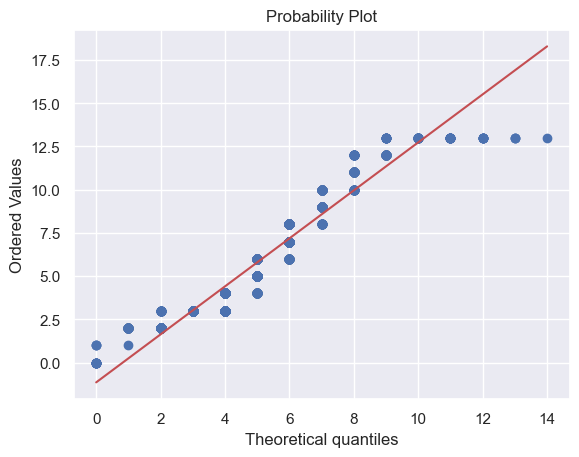

In [ ]:
scipy.stats.probplot(Y, dist="poisson", sparams=(5), plot=plt)
plt.show()

In [ ]:
poisson_model = sm.GLM(Y, X, family=sm.families.Poisson()).fit()

In [ ]:
poisson_model.summary()

Réduction du nombre de variables grâce au critère AIC

In [ ]:
def aic_GLM(X, Y):  # entrer X le dataframe des variables explicatives
    aic_list = []
    for col in X.columns:
        X_temp = X.drop(col, axis=1)
        model_temp = sm.GLM(Y, X_temp, family=sm.families.Poisson()).fit()
        aic_list.append([col, model_temp.aic])

    return aic_list

In [ ]:
def stepwise_GLM(X, Y):
    current_aic = (
        sm.GLM(Y, X, family=sm.families.Poisson()).fit().aic
    )  # aic avec les variables actuelles
    aic_list = aic_GLM(X, Y)  # liste des aic par supression des variables une a une

    my_bool = 0  # pour indiquer si aucune variable n'est a enlever
    for i in range(
        len(aic_list)
    ):  # si l'aic diminue pour une variable supprimee, on enleve cette variable du df X
        if aic_list[i][1] < current_aic:
            del X[aic_list[i][0]]  # a l'interieur des crochets c'est une string
            my_bool = 1

    if my_bool == 0:
        print("Le stepwise est terminé.")

In [ ]:
stepwise_GLM(X_train, Y_train)

In [ ]:
stepwise_GLM(X_train, Y_train)

In [ ]:
poisson_model = sm.GLM(Y_train, X_train, family=sm.families.Poisson()).fit()
Y_test_hat = poisson_model.predict(X_test)

In [ ]:
plt.scatter(Y, Y_hat)
plt.title("Valeurs prédites contres vraies valeurs (valeurs test)")
abline(1, 0)

In [ ]:
print(f"MSE = {mean_squared_error(Y, Y_hat)}")
print(f"RMSE = {mean_squared_error(Y, Y_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y, Y_hat)}")

## Régression polynomiale

In [ ]:
X = df_transforme[
    [
        "Income",
        "NumWebPurchases",
        "NumDealsPurchases",
        "NumWebVisitsMonth",
        "NumCatalogPurchases",
        "MntWines",
        "MntFruits",
        "MntMeatProducts",
        "MntFishProducts",
        "MntSweetProducts",
        "MntGoldProds",
        "Year_Birth",
        "Childhome",
        "Recency",
        "NbAcceptedCampaigns",
    ]
]
Y = df_transforme["NumStorePurchases"]

In [ ]:
# Transformer les données en matrice de caractéristiques polynomiales
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_poly, Y, test_size=0.5)

In [ ]:
# Entraîner un modèle de régression linéaire sur les données transformées
polynomial_model = LinearRegression().fit(X_train, Y_train)

In [ ]:
Y_test_hat = polynomial_model.predict(X_test)
Y_train_hat = polynomial_model.predict(X_train)

In [ ]:
plt.scatter(Y_test_hat, Y_test)
plt.title("Valeurs prédites contres vraies valeurs (valeurs test)")
abline(1, 0)

In [ ]:
print(f"MSE = {mean_squared_error(Y_test, Y_test_hat)}")
print(f"RMSE = {mean_squared_error(Y_test, Y_test_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_test, Y_test_hat)}")

In [ ]:
print(f"MSE = {mean_squared_error(Y_train, Y_train_hat)}")
print(f"RMSE = {mean_squared_error(Y_train, Y_train_hat, squared=False)}")
print(f"MAE = {mean_absolute_error(Y_train, Y_train_hat)}")

On constate que le modèle polynomial s'ajuste mieux aux données d'entraînement, mais est moins bon pour prédire les valeurs de test. Plus le degré des polynômes augmente, plus cet écart s'empire.

Jusqu'alors, le meilleur résultat a été obtenu par la régression linéaire multiple, avec élimination des variables par critères AIC.